AInewsbot.ipynb

- Open URLs of news sites specififed in `sources` dict using Selenium and Firefox
- Save HTML of each URL in htmldata directory
- Extract URLs from all files, create a pandas dataframe with url, title, src
- Use ChatGPT to filter only AI-related headlines by sending a prompt and formatted table of headlines
- Use SQLite to filter headlines previously seen 
- OPENAI_API_KEY should be in the environment or in a .env file
  
Alternative manual workflow to get HTML files if necessary
- Use Chrome, open e.g. Tech News bookmark folder, right-click and open all bookmarks in new window
- on Google News, make sure switch to AI tab
- on Google News, Feedly, Reddit, scroll to additional pages as desired
- Use SingleFile extension, 'save all tabs'
- Move files to htmldata directory
- Run lower part of notebook to process the data


In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
# use firefox because it updates less often, can disable updates
# recommend importing profile from Chrome for cookies, passwords
# looks less like a bot with more user cruft in the profile
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.firefox.service import Service

import bs4
from bs4 import BeautifulSoup
import requests
from urllib.parse import urljoin

import openai
from openai import OpenAI
import tiktoken

import dotenv

import sqlite3

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"openai          {openai.__version__}")
print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

openai          1.14.2
requests        2.31.0
BeautifulSoup   4.12.3


In [2]:
print(datetime.now())

2024-03-29 09:19:49.660217


In [70]:
# load credentials if necessary
dotenv.load_dotenv()
client = OpenAI()

In [4]:
# delete files in output directory
download_dir = "htmldata"

def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')


delete_files(download_dir)

# Specify sources

In [66]:
# load sources from YAML file
with open("sources.yaml", "r") as stream:
    try:
        INDICATORS = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

sources

{'Reddit': {'title': 'top scoring links _ multi',
  'url': 'https://www.reddit.com/r/ChatGPT+ChatGPTCoding+MacOS+MachineLearning+OpenAI+ProgrammerHumor+Windows10+battlestations+buildapc+cordcutters+dataisbeautiful+gadgets+hardware+linux+msp+programming+realtech+software+talesfromtechsupport+tech+technews+technology+techsupportgore+windows/top/?sort=top&t=day',
  'scroll': 2,
  'exclude': ['^https://www.reddit.com/',
   '^https://chat.reddit.com/',
   '^https://i.redd.it/',
   '^https://redditblog.com/',
   '^https://www.redditinc.com/',
   '^https://www.reddithelp.com/',
   '^https://itunes.apple.com/',
   '^https://play.google.com/']},
 'Hacker News': {'title': 'Hacker News Page 1',
  'url': 'https://news.ycombinator.com/',
  'exclude': ['https://news.ycombinator.com/',
   'https://www.ycombinator.com/']},
 'Hacker News 2': {'title': 'Hacker News Page 2',
  'url': 'https://news.ycombinator.com/?p=2',
  'exclude': ['https://news.ycombinator.com/',
   'https://www.ycombinator.com/']},
 

# Download HTML files from sources

In [67]:
# download files via selenium and firefox
outputdir = "htmldata"
delete_files(outputdir)

# Print the formatted time
print(datetime.now().strftime('%H:%M:%S'), "Starting", flush=True)

firefox_app_path = '/Applications/Firefox.app'
# Path to your geckodriver
geckodriver_path = '/Users/drucev/webdrivers/geckodriver'

# Set up Firefox options to use your existing profile
# important for some sites that need a login, also a generic profile fingerprint that looks like a bot might get blocked
firefox_profile_path = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'
options = Options()
options.profile = firefox_profile_path

print(datetime.now().strftime('%H:%M:%S'), "Initialized profile", flush=True)

# Create a Service object with the path
service = Service(geckodriver_path)

print(datetime.now().strftime('%H:%M:%S'), "Initialized service", flush=True)
# Set up the Firefox driver
driver = webdriver.Firefox(service=service, options=options)

print(datetime.now().strftime('%H:%M:%S'), "Initialized webdriver", flush=True)
sleeptime = 10

for sourcename, sourcedict in sources.items():
    print(datetime.now().strftime('%H:%M:%S'), f'Processing {sourcename}', flush=True)
    title = sourcedict["title"]
    url = sourcedict["url"]
    scroll = sourcedict.get("scroll", 0)
    click = sourcedict.get("click")

    # Open the page
    driver.get(url)

    # Wait for the page to load
    time.sleep(sleeptime)  # Adjust the sleep time as necessary

    if click:
        print(datetime.now().strftime('%H:%M:%S'), f"Clicking on {click}", flush=True)
        button = driver.find_element(By.XPATH, click)
        if button:
            button.click()
            print(datetime.now().strftime('%H:%M:%S'), f"Clicked", flush=True)

    for _ in range(scroll):
        # scroll to bottom of infinite scrolling window
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        print(datetime.now().strftime('%H:%M:%S'), "Loading additional infinite scroll items", flush=True)
        time.sleep(sleeptime) # wait for it to load additional items

    # Get the HTML source of the page
    html_source = driver.page_source

    # check encoding, default utf-8
    encoding = "utf-8"  # Default to UTF-8 if not specified
    # Retrieve the content-type meta tag from the HTML
    try:
        meta_tag = driver.find_element(By.XPATH, "//meta[@http-equiv='Content-Type']")
        content_type = meta_tag.get_attribute("content")
        # Typical format is "text/html; charset=UTF-8"
        charset_start = content_type.find("charset=")
        if charset_start != -1:
            encoding = content_type[charset_start + 8:]
    except Exception as err:
        pass

    # Save the HTML to a local file
    datestr = datetime.now().strftime("%m_%d_%Y %I_%M_%S %p")
    outfile = f'{title} ({datestr}).html'
    print(datetime.now().strftime('%H:%M:%S'), f"Saving {outfile} as {encoding}", flush=True)
    with open(outputdir + "/" + outfile, 'w', encoding=encoding) as file:
        file.write(html_source)

# Close the browser
driver.quit()
print(datetime.now().strftime('%H:%M:%S'), "Quit webdriver", flush=True)


17:50:40 Starting
17:51:12 Initialized profile
17:51:12 Initialized service
17:52:27 Initialized webdriver
17:52:27 Processing Reddit
17:52:40 Loading additional infinite scroll items
17:52:50 Loading additional infinite scroll items
17:53:01 Saving top scoring links _ multi (03_29_2024 05_53_01 PM).html as utf-8
17:53:01 Processing Hacker News
17:53:13 Saving Hacker News Page 1 (03_29_2024 05_53_13 PM).html as utf-8
17:53:13 Processing Hacker News 2
17:53:23 Saving Hacker News Page 2 (03_29_2024 05_53_23 PM).html as utf-8
17:53:23 Processing Techmeme
17:53:34 Saving Techmeme (03_29_2024 05_53_34 PM).html as utf-8
17:53:34 Processing Feedly AI
17:53:45 Loading additional infinite scroll items
17:53:55 Loading additional infinite scroll items
17:54:05 Saving Discover and Add New Feedly AI Feeds (03_29_2024 05_54_05 PM).html as utf-8
17:54:05 Processing NYT Tech
17:54:16 Saving Technology - The New York Times (03_29_2024 05_54_16 PM).html as utf-8
17:54:16 Processing WSJ Tech
17:54:28 Sa

In [7]:
[os.path.join(download_dir, file) for file in os.listdir(download_dir)]

['htmldata/Bloomberg Technology - Bloomberg (03_29_2024 09_23_33 AM).html',
 'htmldata/top scoring links _ multi (03_29_2024 09_21_54 AM).html',
 'htmldata/Google News - Technology - Artificial intelligence (03_29_2024 09_24_29 AM).html',
 'htmldata/Technology (03_29_2024 09_23_44 AM).html',
 'htmldata/Technology - The Washington Post (03_29_2024 09_23_55 AM).html',
 'htmldata/Discover and Add New Feedly AI Feeds (03_29_2024 09_22_59 AM).html',
 'htmldata/.gitkeep',
 'htmldata/Tech - Business Insider (03_29_2024 09_25_13 AM).html',
 'htmldata/Hacker News Page 1 (03_29_2024 09_22_07 AM).html',
 'htmldata/Technology - WSJ.com (03_29_2024 09_23_22 AM).html',
 'htmldata/Ars Technica (03_29_2024 09_24_51 AM).html',
 'htmldata/The Register_ Enterprise Technology News and Analysis (03_29_2024 09_25_01 AM).html',
 'htmldata/Technology - The New York Times (03_29_2024 09_23_10 AM).html',
 'htmldata/Hacker News Page 2 (03_29_2024 09_22_17 AM).html',
 'htmldata/HackerNoon - read, write and learn 

In [8]:
# List all paths in the directory matching today's date
nfiles = 50

# Get the current date
today = datetime.now()
year, month, day = today.year, today.month, today.day

datestr = datetime.now().strftime("%m_%d_%Y")

# print(f"Year: {year}, Month: {month}, Day: {day}")

files = [os.path.join(download_dir, file) for file in os.listdir(download_dir)]
# filter files only
files = [file for file in files if os.path.isfile(file)]

# Sort files by modification time and take top 50
files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
file = files[:nfiles]

# filter files by with today's date ending in .html
files = [file for file in files if datestr in file and file.endswith(".html")]
print(len(files))
for file in files:
    print(file)

15
htmldata/Tech - Business Insider (03_29_2024 09_25_13 AM).html
htmldata/The Register_ Enterprise Technology News and Analysis (03_29_2024 09_25_01 AM).html
htmldata/Ars Technica (03_29_2024 09_24_51 AM).html
htmldata/HackerNoon - read, write and learn about any technology (03_29_2024 09_24_40 AM).html
htmldata/Google News - Technology - Artificial intelligence (03_29_2024 09_24_29 AM).html
htmldata/Technology - The Washington Post (03_29_2024 09_23_55 AM).html
htmldata/Technology (03_29_2024 09_23_44 AM).html
htmldata/Bloomberg Technology - Bloomberg (03_29_2024 09_23_33 AM).html
htmldata/Technology - WSJ.com (03_29_2024 09_23_22 AM).html
htmldata/Technology - The New York Times (03_29_2024 09_23_10 AM).html
htmldata/Discover and Add New Feedly AI Feeds (03_29_2024 09_22_59 AM).html
htmldata/Techmeme (03_29_2024 09_22_28 AM).html
htmldata/Hacker News Page 2 (03_29_2024 09_22_17 AM).html
htmldata/Hacker News Page 1 (03_29_2024 09_22_07 AM).html
htmldata/top scoring links _ multi (03_

In [9]:
# you need this if you have not-descriptive link titles like 'link', can get a page title from html or tags
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        print(f"Error fetching {url}: {e}")
    return retdict


url = "https://www.euronews.com/next/2024/01/15/almost-40-of-jobs-around-the-world-will-be-impacted-by-ai-imf-chief-says"
get_og_tags(url)

{'og:locale': 'en-GB',
 'og:url': 'https://www.euronews.com/next/2024/01/15/almost-40-of-jobs-around-the-world-will-be-impacted-by-ai-imf-chief-says',
 'og:site_name': 'euronews',
 'og:type': 'article',
 'og:title': 'AI to impact 40% of jobs around the world, IMF chief says',
 'og:description': 'Kristalina Georgieva said now is the time to act to create a set of policies ensuring the impact of AI is beneficial not detrimental to humanity.',
 'og:image': 'https://static.euronews.com/articles/stories/08/17/12/08/1200x675_cmsv2_1bac2582-b418-5da9-80f9-6c4b6254606d-8171208.jpg',
 'og:image:width': '1200',
 'og:image:height': '675',
 'og:image:type': 'image/jpeg',
 'og:image:alt': 'Almost 40% of jobs around the world will be impacted by AI, IMF chief says',
 'og:locale:alternate': 'el-GR',
 'og:locale:alternate:url': 'https://www.euronews.com/next/2024/01/15/almost-40-of-jobs-around-the-world-will-be-impacted-by-ai-imf-chief-says',
 'title': 'Almost 40% of jobs around the world will be impa

In [10]:
def get_path_from_url(url):
    """
    Extracts the path following the top-level domain name from a URL.

    :param url: The URL string.
    :return: The path component of the URL.
    """
    parsed_url = urlparse(url)
    return parsed_url.path


# Example usage
example_url = "http://www.example.com/some/path?query=string"
path = get_path_from_url(example_url)
print(path)

/some/path


In [11]:
MODEL = "gpt-4-turbo-preview"

MAX_INPUT_TOKENS = 3072
MAX_OUTPUT_TOKENS = 4096
MAX_RETRIES = 3
TEMPERATURE = 0

In [12]:
enc = tiktoken.encoding_for_model(MODEL)
assert enc.decode(enc.encode("hello world")) == "hello world"


def count_tokens(s):
    return len(enc.encode(s))


count_tokens("four score and 7 years go our forefathers brought forth")

13

In [13]:
def trimmed_href(l):
    """
    Trims everything in the string after a question mark such as a session ID.

    :param s: The input string.
    :return: The trimmed string.
    """
    # Find the position of the question mark
    s = l.get("href")
    if s:
        question_mark_index = s.find("?")

        # If a question mark is found, trim the string up to that point
        if question_mark_index != -1:
            return s[:question_mark_index]
        else:
            # Return the original string if no question mark is found
            return s
    else:
        return s

# Parse news URLs and titles from downloaded HTML files

In [14]:
# parse all the URL that look like news articles
# into all_urls list of dicts with url, title, src
all_urls = []

for file in files:
    # Extract filename from path
    filename = os.path.basename(file)

    # Find the position of '1_14_2024' in the filename
    position = filename.find(" (" + datestr)
    basename = filename[:position]
#     print(basename)
#     if basename.startswith('Google News'):
#         pass
#     else:
#         continue

    sourcename = sources_reverse.get(basename)
    if sourcename is None:
        print(f"Skipping {basename}, no sourcename metadata")
        continue

    display(Markdown(f"# {sourcename}"))
    sources[sourcename]["latest"] = file

    # get contents
    with open(file, "r") as file:
        html_content = file.read()

    # Parse the HTML content
    soup = BeautifulSoup(html_content, "html.parser")

    # Find all <a> tags
    if soup:
        links = soup.find_all("a")
    else:
        print(f"Skipping {sourcename}, unable to parse")

    # convert relative links to absolute links using base URL if present
    base_tag = soup.find('base')
    base_url = base_tag.get('href') if base_tag else sources[sourcename]["url"]
    for link in links:
#         print(link.get("href"))
        link["href"]= urljoin(base_url, link.get('href', ""))
#         print(link["href"])

#     print(len(links))
#     links = [l for l in links if l]
#     links = [l.strip() for l in links]

    print(len(links))

    for pattern in sources[sourcename].get("exclude", []):
        # filter links by exclusion pattern
#         print(pattern)
#         print([ l.get("href") for l in links])
        links = [
            l
            for l in links
            if l.get("href") is not None and not re.match(pattern, l.get("href"))
        ]
        # print(len(links))

    for pattern in sources[sourcename].get("include", []):
        # print(pattern, len(links))
        # filter links by inclusion pattern
        # print(pattern)
        # print(type(pattern))
        newlinks = []
        for l in links:
            href = l.get("href")
#             print(href)
            if href and re.match(pattern, href):
                newlinks.append(l)
        links = newlinks
        # links = [l for l in links if re.match(pattern, l.get("href"))]
        # print(len(links))

    # drop empty text
    links = [l for l in links if l.get_text(strip=True)]

    # drop empty url path, i.e. url = toplevel domain
    links = [l for l in links if len(get_path_from_url(trimmed_href(l))) > 1]
    # drop anything that is not http, like javascript: or mailto:
    links = [l for l in links if l.get("href") and l.get("href").startswith("http")]
    # drop some ArsTechnica links that are just the number of comments and dupe the primary link
    links = [l for l in links if not re.match("^(\d+)$", l.get_text(strip=True))]

    for l in links:
        url = trimmed_href(l)
        title = l.get_text(strip=True)
        if title == "LINK":
            # try to update title
            og_dict = get_og_tags(url)
            if og_dict.get("og:title"):
                title = og_dict.get("og:title")

        # skip some low quality links that don't have full headline, like link to a Twitter or Threads account
        if len(title) <= 28 and title != "LINK":
            continue

        all_urls.append({"title": title, "url": url, "src": sourcename})
#         display(Markdown(f"[{title}]({url})"))

    print(len(links))
    print()

    # for p in pages:
    #     print(p)

# Business Insider

334
249



# The Register

200
88



# Ars Technica

252
7



# HackerNoon

557
83



# Google News

989
430



# WaPo Tech

155
35



# FT Tech

459
115



# Bloomberg Tech

295
48



# WSJ Tech

496
9



# NYT Tech

77
18



# Feedly AI

242
227



# Techmeme

398
172



# Hacker News 2

261
30



# Hacker News

254
24



# Reddit

556
44



In [15]:
# make a pandas dataframe
orig_df = (
    pd.DataFrame(all_urls)
    .groupby("url")
    .first()
    .reset_index()
    .sort_values("src")[["src", "title", "url"]]
    .reset_index(drop=True)
    .reset_index(drop=False)
    .rename(columns={"index": "id"})
)
orig_df

,id,src,title,url
0,0,Ars Technica,Explaining why your keyboard feels so darn goo...,https://arstechnica.com/gadgets/2024/03/the-ar...
1,1,Ars Technica,Apple’s first new 3D Vision Pro video since la...,https://arstechnica.com/gadgets/2024/03/apple-...
2,2,Ars Technica,"Google’s Pixel 9 might have three models, addi...",https://arstechnica.com/gadgets/2024/03/google...
3,3,Ars Technica,"Intel, Microsoft discuss plans to run Copilot ...",https://arstechnica.com/gadgets/2024/03/intel-...
4,4,Ars Technica,"Facebook let Netflix see user DMs, quit stream...",https://arstechnica.com/gadgets/2024/03/netfli...
...,...,...,...,...
1036,1036,WaPo Tech,Gen Z embraces side hustles because ‘loyalty i...,https://www.washingtonpost.com/technology/2024...
1037,1037,WaPo Tech,"Musk tried to ‘punish’ critics, judge rules, i...",https://www.washingtonpost.com/technology/2024...
1038,1038,WaPo Tech,Trump Media soars in first day of public trading,https://www.washingtonpost.com/technology/2024...
1039,1039,WaPo Tech,Reddit’s shares soar in stock market debut,https://www.washingtonpost.com/technology/2024...


In [16]:
# filter ones not seen before
conn = sqlite3.connect('articles.db')

# Retrieve all URLs from the SQLite table
existing_urls = pd.read_sql_query("SELECT url FROM news_articles", conn)

# Close the SQLite connection
conn.close()

# Convert the URLs to a list for easier comparison
existing_urls_list = existing_urls['url'].tolist()

# Filter the original DataFrame
# Keep rows where the URL is not in the existing_urls_list
filtered_df = orig_df[~orig_df['url'].isin(existing_urls_list)]


In [17]:
len(existing_urls_list)

30509

In [18]:
len(filtered_df)

357

# Filter AI-related headlines using a prompt to OpenAI

In [19]:
# make pages that fit in a reasonably sized prompt
MAXPAGELEN = 50
pages = []
current_page = []
pagelength = 0

for row in filtered_df.itertuples():
    curlink = {"id": row.Index, "title": row.title}
    curlength = count_tokens(json.dumps(curlink))
    # Check if adding the current string would exceed the limit
    if len(current_page) >= MAXPAGELEN or pagelength + curlength > MAX_INPUT_TOKENS:
        # If so, start a new page
        pages.append(current_page)
        current_page = [curlink]
        pagelength = curlength
    else:
        # Otherwise, add the string to the current page
        current_page.append(curlink)
        pagelength += curlength

# add the last page if it's not empty
if current_page:
    pages.append(current_page)

len(pages)

8

In [20]:
def get_response_json(
    client,
    messages,
    verbose=False,
    model=MODEL,
    # max_input_tokens=MAX_INPUT_TOKENS,
    max_output_tokens=MAX_OUTPUT_TOKENS,
    max_retries=MAX_RETRIES,
    temperature=TEMPERATURE,
):
    if type(messages) != list:  # allow passing one string for convenience
        messages = [{"role": "user", "content": messages}]

    if verbose:
        print("\n".join([str(msg) for msg in messages]))

    # truncate number of tokens
    # retry loop, have received untrapped 500 errors like too busy
    for i in range(max_retries):
        if i > 0:
            print(f"Attempt {i+1}...")
        try:
            response = client.chat.completions.create(
                model=MODEL,
                messages=messages,
                temperature=0,
                max_tokens=max_output_tokens,
                response_format={"type": "json_object"},
            )
            # no exception thrown
            return response
        except Exception as error:
            print(f"An exception occurred on attempt {i+1}:", error)
            time.sleep(5)
            continue  # try again
        # retries exceeded if you got this far
    print("Retries exceeded.")
    return None


# messages = [
#     {
#         "role": "system",
#         "content": "You are a poetic assistant, skilled in explaining complex programming concepts with creative flair.",
#     },
#     {
#         "role": "user",
#         "content": "Compose a poem that explains the concept of recursion in programming, returning each verse as a json object.",
#     },
# ]

# response = get_response_json(client, messages)
# response

In [21]:
models = sorted(openai.models.list(), key=lambda m: m.created)
models

[Model(id='text-embedding-ada-002', created=1671217299, object='model', owned_by='openai-internal'),
 Model(id='whisper-1', created=1677532384, object='model', owned_by='openai-internal'),
 Model(id='gpt-3.5-turbo', created=1677610602, object='model', owned_by='openai'),
 Model(id='gpt-3.5-turbo-0301', created=1677649963, object='model', owned_by='openai'),
 Model(id='tts-1', created=1681940951, object='model', owned_by='openai-internal'),
 Model(id='gpt-3.5-turbo-16k', created=1683758102, object='model', owned_by='openai-internal'),
 Model(id='gpt-3.5-turbo-16k-0613', created=1685474247, object='model', owned_by='openai'),
 Model(id='gpt-3.5-turbo-0613', created=1686587434, object='model', owned_by='openai'),
 Model(id='gpt-4-0613', created=1686588896, object='model', owned_by='openai'),
 Model(id='gpt-4', created=1687882411, object='model', owned_by='openai'),
 Model(id='davinci-002', created=1692634301, object='model', owned_by='system'),
 Model(id='babbage-002', created=1692634615,

In [22]:
prompt = """
You will act as a research assistant classifying news stories as related to artificial intelligence (AI) or unrelated to AI.

Your task is to read JSON format objects from an input list of news stories using the schema below delimited by |, and output JSON format objects for each using the schema below delimited by ~.

Define a list of objects representing news stories in JSON format as in the following example:
|
{'stories':
[{'id': 97, 'title': 'AI to predict dementia, detect cancer'},
 {'id': 103,'title': 'Figure robot learns to make coffee by watching humans for 10 hours'},
 {'id': 103,'title': 'Baby trapped in refrigerator eats own foot'},
 {'id': 210,'title': 'ChatGPT removes, then reinstates a summarization assistant without explanation.'},
 {'id': 298,'title': 'The 5 most interesting PC monitors from CES 2024'},
 ]
}
|

Based on the title, you will classify each story as being about AI or not.

For each object, you will output the input id field, and a field named isAI which is true if the input title is about AI and false if the input title is not about AI.

When extracting information please make sure it matches the JSON format below exactly. Do not output any attributes that do not appear in the schema below.
~
{'stories':
[{'id': 97, 'isAI': true},
 {'id': 103, 'isAI': true},
 {'id': 103, 'isAI': false},
 {'id': 210, 'isAI': true},
 {'id': 298, 'isAI': false}]
}
~

You may interpret the term AI broadly as pertaining to
- machine learning models
- large language models
- robotics
- reinforcement learning
- computer vision
- OpenAI
- ChatGPT
- other closely related topics.

You will return an array of valid JSON objects.

The field 'id' in the output must match the field 'id' in the input EXACTLY.

The field 'isAI' must be either true or false.

The list of news stories to classify and enrich is:


"""

In [23]:
pages[0][0]

{'id': 9,
 'title': 'Tech CEOs Find Friendly Podcast Hosts Help Get Out Their Talking Points'}

In [24]:
responses = []
enriched_urls = []
for i, p in enumerate(pages):
    print(
        f"{datetime.now().strftime('%H:%M:%S')} send page {i+1} of {len(pages)}, {len(p)} items "
    )
    # print(prompt + json.dumps(p))
    response = get_response_json(client, prompt + json.dumps(p))
    responses.append(response.choices[0].message.content)
    retval = json.loads(responses[-1])
    retlist = []
    # usually comes back as a dict with a single arbitrary key like "stories" with a list value
    if type(retval) == dict:
        for k, v in retval.items():
            if type(v) == list:
                retlist.extend(v)
            else:
                retlist.append(v)
        print(
            f"{datetime.now().strftime('%H:%M:%S')} got dict with {len(retlist)} items "
        )
    elif type(retval) == list:  # in case it comes back as a list
        retlist = retval
        print(
            f"{datetime.now().strftime('%H:%M:%S')} got list with {len(retlist)} items "
        )
    else:
        print(str(type(retval)))
    enriched_urls.extend(retlist)

09:25:22 send page 1 of 8, 50 items 
09:25:44 got dict with 50 items 
09:25:44 send page 2 of 8, 50 items 
09:26:03 got dict with 50 items 
09:26:03 send page 3 of 8, 50 items 
09:26:27 got dict with 50 items 
09:26:27 send page 4 of 8, 50 items 
09:26:50 got dict with 50 items 
09:26:50 send page 5 of 8, 50 items 
09:27:18 got dict with 50 items 
09:27:18 send page 6 of 8, 50 items 
09:27:40 got dict with 50 items 
09:27:40 send page 7 of 8, 50 items 
09:27:59 got dict with 50 items 
09:27:59 send page 8 of 8, 7 items 
09:28:03 got dict with 7 items 


In [25]:
enriched_df = pd.DataFrame(enriched_urls)
enriched_df.head()

,id,isAI
0,9,False
1,14,False
2,29,False
3,31,False
4,33,False


In [26]:
print("isAI", len(enriched_df.loc[enriched_df["isAI"]]))
print("not isAI", len(enriched_df.loc[~enriched_df["isAI"]]))

isAI 141
not isAI 216


In [27]:
merged_df = pd.merge(filtered_df, enriched_df, on="id", how="outer")
merged_df['date']=datetime.now().date()
merged_df.head()

,id,src,title,url,isAI,date
0,9,Bloomberg Tech,Tech CEOs Find Friendly Podcast Hosts Help Get...,https://www.bloomberg.com/news/newsletters/202...,False,2024-03-29
1,14,Bloomberg Tech,Microsoft-Backed Rubrik Is Ready to File Next ...,https://www.bloomberg.com/news/articles/2024-0...,False,2024-03-29
2,29,Bloomberg Tech,South Korea’s Semiconductor Output Rises by Mo...,https://www.bloomberg.com/news/articles/2024-0...,False,2024-03-29
3,31,Bloomberg Tech,Huawei Profit Surges as It Takes Share From Ap...,https://www.bloomberg.com/news/articles/2024-0...,False,2024-03-29
4,33,Bloomberg Tech,Drive to Survive Star Guenther Steiner on Miam...,https://www.bloomberg.com/news/articles/2024-0...,False,2024-03-29


In [28]:
# ideally should be empty, shouldn't get back rows that don't match to existing
merged_df.loc[merged_df["src"].isna()]

,id,src,title,url,isAI,date


In [29]:
# ideally should be empty, should get back all rows from orig
merged_df.loc[merged_df["isAI"].isna()]

,id,src,title,url,isAI,date


In [30]:
# # Connect to SQLite database
conn = sqlite3.connect('articles.db')
cursor = conn.cursor()

# # Create table with a date column
# cursor.execute('''
# CREATE TABLE IF NOT EXISTS news_articles (
#     id INTEGER PRIMARY KEY,
#     src TEXT,
#     title TEXT,
#     url TEXT UNIQUE,
#     isAI BOOLEAN,
#     article_date DATE
# )
# ''')
# conn.commit()
# conn.close()

In [31]:
# Function to insert a new article
def insert_article(cursor, src, title, url, isAI, article_date):
    try:
        cursor.execute("INSERT OR IGNORE INTO news_articles (src, title, url, isAI, article_date) VALUES (?, ?, ?, ?, ?)",
                       (src, title, url, isAI, article_date))
        conn.commit()
    except sqlite3.IntegrityError:
        print(f"Duplicate entry for URL: {url}")
    except Exception as err:
        print(err)

In [32]:
pd.read_sql_query("select count(*) from news_articles", conn)


,count(*)
0,30509


In [33]:
for row in merged_df.itertuples():
    # print(row)
    insert_article(cursor, row.src, row.title, row.url, row.isAI, row.date)


In [34]:
pd.read_sql_query("select count(*) from news_articles", conn)


,count(*)
0,30866


In [35]:
df = pd.read_sql_query("select * from news_articles", conn)
df


,id,src,title,url,isAI,article_date
0,1,Ars Technica,OnePlus 12 gets $800 US release along with the...,https://arstechnica.com/gadgets/2024/01/oneplu...,0,2024-01-24
1,2,Ars Technica,Chrome can now organize your tab bar for you,https://arstechnica.com/gadgets/2024/01/chrome...,0,2024-01-24
2,3,Ars Technica,HP CEO evokes James Bond-style hack via ink ca...,https://arstechnica.com/gadgets/2024/01/hp-ceo...,0,2024-01-24
3,4,Ars Technica,iOS 17.3 adds multiple features originally pla...,https://arstechnica.com/gadgets/2024/01/ios-17...,0,2024-01-24
4,5,Ars Technica,Wild Apples: The 12 weirdest and rarest Macs e...,https://arstechnica.com/gadgets/2024/01/macint...,0,2024-01-24
...,...,...,...,...,...,...
30861,30862,The Register,Microsoft rolls out safety tools for Azure AI....,https://www.theregister.com/2024/03/29/microso...,1,2024-03-29
30862,30863,The Register,Amazon fined in Europe for screwing shoppers w...,https://www.theregister.com/2024/03/29/amazon_...,0,2024-03-29
30863,30864,The Register,"Farewell .NET 7, support ends in May - we hard...",https://www.theregister.com/2024/03/29/dotnet_...,0,2024-03-29
30864,30865,The Register,Hillary Clinton: 2024 will be 'ground zero' fo...,https://www.theregister.com/2024/03/29/hillary...,1,2024-03-29


In [36]:
len(merged_df.loc[merged_df["isAI"]])

141

In [37]:
AIdf = merged_df.loc[merged_df["isAI"]].reset_index()


In [38]:
# Attempt to order by topic by getting embeddings and solving a traveling salesman problem
embedding_model = 'text-embedding-3-small'
response = client.embeddings.create(input=AIdf['title'].tolist(),
                                    model=embedding_model)
embedding_list = response.data

In [39]:
embedding_df = pd.DataFrame([e.dict()['embedding'] for e in embedding_list])
embedding_df


,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
0,0.002582,-0.006159,0.024881,0.056909,0.033447,-0.035330,-0.003490,0.045478,0.022262,-0.044169,...,-0.060729,-0.012986,0.033093,0.016792,0.021893,0.037458,0.027636,0.001975,0.039995,-0.000850
1,0.008577,-0.000933,0.071857,0.027055,-0.003931,-0.004827,-0.004386,0.031101,0.013123,0.005893,...,-0.002522,0.041189,0.003978,0.011742,0.003129,0.009365,0.019583,0.004101,-0.024121,0.018456
2,0.016636,-0.029663,0.029832,0.030537,0.001967,-0.036036,-0.013492,-0.014916,0.011095,-0.028042,...,-0.048724,0.027168,0.000379,-0.009827,0.015395,-0.002962,0.002159,0.019343,0.011702,0.006640
3,-0.010392,0.018196,0.030686,0.046871,0.051621,-0.048605,-0.002193,0.057502,0.005193,-0.020269,...,0.008250,0.010147,-0.005843,0.004923,-0.001943,0.008878,-0.013622,-0.022292,0.013295,0.013081
4,-0.014357,-0.022761,0.041740,-0.006832,-0.016444,-0.014441,0.027285,-0.002675,-0.023041,0.001374,...,-0.031543,0.014329,-0.010183,0.001283,0.048491,0.011626,-0.008544,-0.004360,-0.004093,0.021542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,-0.008556,-0.004638,-0.006529,0.039581,0.033882,-0.052974,-0.025760,0.065313,-0.020945,-0.009917,...,-0.004599,-0.004349,-0.012182,0.009696,0.008556,0.021814,-0.019320,-0.016357,0.030035,-0.013500
137,-0.008184,0.039025,0.015846,0.020982,-0.007518,-0.059429,-0.016299,0.047428,0.005527,-0.039821,...,-0.042814,0.038997,0.045561,0.038091,0.012791,0.026241,-0.036443,-0.027092,-0.027600,0.016903
138,-0.000002,-0.027671,-0.004337,0.055931,0.000066,-0.026492,-0.026591,0.058043,-0.011411,-0.029365,...,0.021078,0.032950,0.000160,0.029365,0.032630,0.021263,0.021975,-0.009158,0.010269,0.027499
139,-0.005980,0.007918,0.053330,0.028500,-0.005187,-0.040474,0.022141,0.056834,-0.035314,0.044253,...,-0.011636,0.035149,-0.015892,0.040032,0.008546,-0.016374,-0.001974,-0.000450,-0.016733,-0.013277


In [40]:
# naive greedy solution to traveling salesman problem

embedding_array = embedding_df.values

def nearest_neighbor_sort(embedding_array):
    # Compute the pairwise Euclidean distances between all embeddings
    distances = cdist(embedding_array, embedding_array, metric='euclidean')

    # Start from the first headline as the initial point
    path = [0]
    visited = set(path)

    while len(path) < len(embedding_array):
        last = path[-1]
        # Set the distances to already visited nodes to infinity to avoid revisiting
        distances[:, last][list(visited)] = np.inf
        # Find the nearest neighbor
        nearest = np.argmin(distances[:, last])
        path.append(nearest)
        visited.add(nearest)

    return np.array(path)

# Get the sorted indices
sorted_indices = nearest_neighbor_sort(embedding_array)

# The sorted embedding array can be obtained using these indices
sorted_embedding_array = embedding_array[sorted_indices]

sorted_indices  # Show the first few indices of the sorted path


array([  0,  50,  56,  35, 107,  81, 118,  14,  25,  48, 130, 112, 114,
        30,  32,  88,  55,  62,  24, 123,  15,  19, 138,  26,  74,  44,
        98,  53,  97,  94,  99, 131,   8,  86, 122,  43, 140,  91,  41,
        54,   1,  42, 111, 125,  17,  58,  46, 139, 128,  83,  45, 132,
       103,  92,  10,  18,  89,  49,  59,  95, 110,  90,  33, 129, 105,
       108,  72, 117,  85,  79, 126,  80,  63,  47,  67,  84,  69,  66,
       101,  37,  39, 102, 120,  60,  75, 119, 104,  87,   2, 115,  51,
        82,  68,  16,  11, 113,  76,  77,  28, 124,  36, 116, 109, 137,
         6,   4, 127,  29,  22, 106,  20,   9,   7,  40,   5,  27,  34,
        96,  65,  71,  64,  61, 100,  57,  93,   3,  70,  52, 121, 136,
        23,  31,  78,  73, 133, 135,  12, 134,  21,  38,  13])

In [96]:
html_str = ""
for i, j in enumerate(sorted_indices):
    row = AIdf.iloc[j]
    html_str += f'{i}.<a href="{row.url}">{row.title} - {row.src}</a><br />\n'
    display_title = row.title.replace("$", "\\\$")  # so it doesn't interpret as latex escape
    display(Markdown(f"[{i}. {display_title} - {row.src}]({row.url})"))
    

[0. Sam Altman is trying to convince Hollywood that Sora won't destroy the movie business - Business Insider](https://www.businessinsider.com/sam-altman-openai-convince-sora-wont-destroy-hollywood-2024-3)

[1. Amazon Adds \\$2.75 Billion To Anthropic Investment, Sora Goes To Hollywood - Google News](https://news.google.com/articles/CBMie2h0dHBzOi8vd3d3LmZvcmJlcy5jb20vc2l0ZXMvY2hhcmxpZWZpbmsvMjAyNC8wMy8yOC9hbWF6b24tYWRkcy0yNzUtYmlsbGlvbi10by1hbnRocm9waWMtaW52ZXN0bWVudC1zb3JhLWdvZXMtdG8taG9sbHl3b29kL9IBAA)

[2. Why Amazon's multi-billion dollar AI alliance with Anthropic isn't the game-changer it needs to remain king of the cloud - Google News](https://news.google.com/articles/CBMib2h0dHBzOi8vZm9ydHVuZS5jb20vMjAyNC8wMy8yOC9hbWF6b24tYXdzLWFudGhyb3BpYy1haS1kZWFsLXJldmVhbHMtdnVsbmVyYWJpbGl5LWNsb3VkLWVtcGlyZS1taWNyb3NvZnQtZ29vZ2xlL9IBAA)

[3. Amazon’s Next Phase of Growth Will Be Driven by AI. Analyst Sees Bonanza for AWS. - Feedly AI](https://www.barrons.com/articles/amazon-revenue-growth-ai-d70d858d)

[4. Amazon pours \\$150B into data centers to handle expected AI boom - Google News](https://news.google.com/articles/CBMiZmh0dHBzOi8vbnlwb3N0LmNvbS8yMDI0LzAzLzI4L2J1c2luZXNzL2FtYXpvbi1wb3Vycy0xNTBiLWludG8tZGF0YS1jZW50ZXJzLXRvLWhhbmRsZS1leHBlY3RlZC1haS1ib29tL9IBAA)

[5. Amazon Bets \\$150 Billion on Data Centers Required for AI Boom - Google News](https://news.google.com/articles/CBMiSmh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vbmV3cy9hbWF6b24tYmV0cy0xNTAtYmlsbGlvbi1kYXRhLTExMzAxOTk4NC5odG1s0gEA)

[6. Amazon to Invest \\$150 Billion In AI-Supporting Data Centers - Google News](https://news.google.com/articles/CBMiVmh0dHBzOi8vd3d3LndlYnByb25ld3MuY29tL2FtYXpvbi10by1pbnZlc3QtMTUwLWJpbGxpb24taW4tYWktc3VwcG9ydGluZy1kYXRhLWNlbnRlcnMv0gEA)

[7. Amazon reportedly to spend \\$150B to build data centers needed for AI boom, ‘get closer to customers’ - Feedly AI](https://nypost.com/2024/03/28/business/amazon-pours-150b-into-data-centers-to-handle-expected-ai-boom/)

[8. Nvidia, Amazon And Microsoft's Recent Activity Indicate Impending AI Bubble: 'When The Music Stops There Will Not Be Many Chairs Available' - Feedly AI](https://www.benzinga.com/analyst-ratings/analyst-color/24/03/38001796/nvidia-amazon-and-microsofts-recent-activity-indicate-impending-ai-bubble-when-the-)

[9. 'The frenzy continues': Researcher names 3 new signs of an AI bubble amid Nvidia hype - Google News](https://news.google.com/articles/CBMid2h0dHBzOi8vd3d3LmNuYmMuY29tLzIwMjQvMDMvMjkvdGhlLWZyZW56eS1jb250aW51ZXMtcmVzZWFyY2hlci1uYW1lcy0zLW5ldy1zaWducy1vZi1hbi1haS1idWJibGUtYW1pZC1udmlkaWEtaHlwZS5odG1s0gEA)

[10. Nvidia Stock Had a Blockbuster Q1 Amid AI-Driven Frenzy—Watch This Key Chart Pattern - Google News](https://news.google.com/articles/CBMiXGh0dHBzOi8vd3d3LmludmVzdG9wZWRpYS5jb20vbnZpZGlhLXN0b2NrLWhhZC1hLWJsb2NrYnVzdGVyLXExLWFtaWQtYWktZHJpdmVuLWZyZW56eS04NjIyMDEx0gEA)

[11. Meet the Artificial Intelligence (AI) Stock That Attracted Nvidia's Biggest Investment - Google News](https://news.google.com/articles/CBMiWWh0dHBzOi8vd3d3LmZvb2wuY29tL2ludmVzdGluZy8yMDI0LzAzLzI4L252aWRpYXMtZmF2b3JpdGUtYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2Utc3RvY2sv0gEA)

[12. Billionaire David Tepper Is Loading Up on These Artificial Intelligence (AI) Stocks -- and Nvidia Isn't One of Them - Google News](https://news.google.com/articles/CBMiWWh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vbmV3cy9iaWxsaW9uYWlyZS1kYXZpZC10ZXBwZXItbG9hZGluZy1hcnRpZmljaWFsLTA5NDcwMDI3My5odG1s0gEA)

[13. 1Artificial Intelligence(AI) Stock to Buy Hand Over Fist Before It Jumps 45% - Feedly AI](https://www.fool.com/investing/2024/03/29/1-artificial-intelligence-ai-stock-to-buy-hand-ove/)

[14. Artificial intelligenceboom drives sharemarkets to best first quarter in five years - Feedly AI](https://www.nzherald.co.nz/business/artificial-intelligence-boom-drives-sharemarkets-to-best-first-quarter-in-five-years/FGK2JIFWWBFGNCPMSY7P5OZDDA/)

[15. AI boom drives global stock markets to best first quarter in 5 years - Google News](https://news.google.com/articles/CBMiP2h0dHBzOi8vd3d3LmZ0LmNvbS9jb250ZW50LzFmNDcxYzg4LWQ0OWYtNGE1Mi04NjE5LWNjNWMwYzUwNjAwONIBAA)

[16. AI Boom Flourishes Thanks to The Fed And Record Week - Google News](https://news.google.com/articles/CBMibGh0dHBzOi8vaW52ZXN0b3JwbGFjZS5jb20vaHlwZXJncm93dGhpbnZlc3RpbmcvMjAyNC8wMy9haS1ib29tLWZsb3VyaXNoZXMtdGhhbmtzLXRvLXRoZS1mZWQtYW5kLXJlY29yZC13ZWVrL9IBAA)

[17. J.P. Morgan U.S. equity head eyes AI and health 'game changers' - Google News](https://news.google.com/articles/CBMibmh0dHBzOi8vYXNpYS5uaWtrZWkuY29tL0VkaXRvci1zLVBpY2tzL0ludGVydmlldy9KLlAuLU1vcmdhbi1VLlMuLWVxdWl0eS1oZWFkLWV5ZXMtQUktYW5kLWhlYWx0aC1nYW1lLWNoYW5nZXJz0gEA)

[18. Mary Meeker Turns Her Attention to AI. Here’s How She’s Investing Today. - Feedly AI](https://www.barrons.com/articles/ai-startups-investing-mary-meeker-f5c6bcb2)

[19. Scale AI Nears \\$13 Billion Valuation in Accel-Led Round - Google News](https://news.google.com/articles/CBMiXmh0dHBzOi8vd3d3LnRoZWluZm9ybWF0aW9uLmNvbS9hcnRpY2xlcy9zY2FsZS1haS1uZWFycy0xMy1iaWxsaW9uLXZhbHVhdGlvbi1pbi1hY2NlbC1sZWQtcm91bmTSAQA)

[20. Sources: Accel is in talks to lead a round in Scale AI at a \\$13B valuation, up from \\$7.3B in 2021; Scale AI generated \\$675M+ in revenue in 2023, up ~150% YoY (The Information) - Feedly AI](https://www.theinformation.com/articles/scale-ai-nears-13-billion-valuation-in-accel-led-round)

[21. Startup looking to disrupt ERP market with AI raises \\$9.2M - Feedly AI](https://www.cfodive.com/news/startup-looking-to-disrupt-erp-market-with-ai-raises-92m/711667/)

[22. New York-based The Brandtech Group, which provides generative AI-based tools for advertising and marketing campaigns, raised a \\$115M Series C at a \\$4B valuation - Techmeme](https://t.co/eHtc1eEAa2)

[23. Salesforce Spends \\$20M on Einstein Image Rights, Securing AI Brand Dominance and Guinness Record - Feedly AI](https://www.benzinga.com/news/24/03/37983904/salesforce-spends-20m-on-einstein-image-rights-securing-ai-brand-dominance-and-guinness-record)

[24. Adobe Just Demonstrated How AI Can Create Stellar Marketing Materials for Coca-Cola--or Any Company - Google News](https://news.google.com/articles/CBMihgFodHRwczovL3d3dy5pbmMuY29tL2Jlbi1zaGVycnkvYWRvYmUtanVzdC1kZW1vbnN0cmF0ZWQtaG93LWFpLWNhbi1jcmVhdGUtc3RlbGxhci1tYXJrZXRpbmctbWF0ZXJpYWxzLWZvci1jb2NhLWNvbGEtb3ItYW55LWNvbXBhbnkuaHRtbNIBAA)

[25. How to make impressive PowerPoint presentations using AI - Feedly AI](https://www.geeky-gadgets.com/make-powerpoint-using-ai/)

[26. How AI Changes Your Workforce - Google News](https://news.google.com/articles/CBMiQmh0dHBzOi8vc2xvYW5yZXZpZXcubWl0LmVkdS9hcnRpY2xlL2hvdy1haS1jaGFuZ2VzLXlvdXItd29ya2ZvcmNlL9IBAA)

[27. Productivity Boost: Real Uses of AI in the Software You Already Have - Google News](https://news.google.com/articles/CBMie2h0dHBzOi8vbGVnYWx0YWxrbmV0d29yay5jb20vcG9kY2FzdHMvbmV3LXNvbG8vMjAyNC8wMy9wcm9kdWN0aXZpdHktYm9vc3QtcmVhbC11c2VzLW9mLWFpLWluLXRoZS1zb2Z0d2FyZS15b3UtYWxyZWFkeS1oYXZlL9IBAA)

[28. The 7 Best AI Tools for Data Science Workflow - Google News](https://news.google.com/articles/CBMiR2h0dHBzOi8vd3d3LmtkbnVnZ2V0cy5jb20vdGhlLTctYmVzdC1haS10b29scy1mb3ItZGF0YS1zY2llbmNlLXdvcmtmbG930gEA)

[29. 15 Artificial Intelligence Tools to Experiment with at Home - Google News](https://news.google.com/articles/CBMiRWh0dHBzOi8vd3d3LmJvc3Rvbm1hZ2F6aW5lLmNvbS9uZXdzLzIwMjQvMDMvMjgvaG93LXRvLXVzZS1haS1hdC1ob21lL9IBAA)

[30. 5 FREE AI Websites That Will Save You Hundreds of Dollars | Tap to know more | Inshorts - Google News](https://news.google.com/articles/CBMiZGh0dHBzOi8vaW5zaG9ydHMuY29tL2VuL25ld3MvNS1mcmVlLWFpLXdlYnNpdGVzLXRoYXQtd2lsbC1zYXZlLXlvdS1odW5kcmVkcy1vZi1kb2xsYXJzLTE3MTE1NTMzNjc1ODLSAWhodHRwczovL2luc2hvcnRzLmNvbS9lbi9hbXBfbmV3cy81LWZyZWUtYWktd2Vic2l0ZXMtdGhhdC13aWxsLXNhdmUteW91LWh1bmRyZWRzLW9mLWRvbGxhcnMtMTcxMTU1MzM2NzU4Mg)

[31. Google.org shares new report on AI use among nonprofits - Google News](https://news.google.com/articles/CBMiX2h0dHBzOi8vYmxvZy5nb29nbGUvb3V0cmVhY2gtaW5pdGlhdGl2ZXMvZ29vZ2xlLW9yZy9nb29nbGUtZm9yLW5vbnByb2ZpdHMtZ2VuZXJhdGl2ZS1haS1yZXBvcnQv0gEA)

[32. The White House Just Released New AI Guidelines - Feedly AI](https://flipboard.com/video/veuer/cef59a572b)

[33. The White House issued new rules on how government can use AI. Here's what they do - Google News](https://news.google.com/articles/CBMiPWh0dHBzOi8vd3d3Lm5wci5vcmcvMjAyNC8wMy8yOS8xMjQxMjgxODkyL2JpZGVuLWdvdmVybm1lbnQtYWnSAQA)

[34. Fretting about election-year deep fakes, states roll out new rules for A.I. content. - Google News](https://news.google.com/articles/CBMiVWh0dHBzOi8vd3d3Lm55dGltZXMuY29tLzIwMjQvMDMvMjYvdXMvcG9saXRpY3MvZWxlY3Rpb24teWVhci1kZWVwLWZha2VzLWFpLXJ1bGVzLmh0bWzSAQA)

[35. States rush to combat AI threat to elections - Feedly AI](https://indianacapitalchronicle.com/2024/03/29/states-rush-to-combat-ai-threat-to-elections/)

[36. Hillary Clinton: 2024 will be 'ground zero' for AI election manipulation2016 meddling was 'primitive' compared to what's aheadAI + ML13 hrs|18 - The Register](https://www.theregister.com/2024/03/29/hillary_clinton_election_ai/)

[37. Could artificial intelligence benefit democracy? - Google News](https://news.google.com/articles/CBMiLWh0dHBzOi8vd3d3LmJiYy5jb20vbmV3cy91ay1wb2xpdGljcy02ODYyNzkxNtIBMWh0dHBzOi8vd3d3LmJiYy5jb20vbmV3cy91ay1wb2xpdGljcy02ODYyNzkxNi5hbXA)

[38. A bright or dystopian future with AI? - Feedly AI](https://www.iowapublicradio.org/podcast/talk-of-iowa/2024-03-29/a-bright-or-dystopian-future-with-ai)

[39. AI is on a fast track, but hype and immaturity could derail it - Google News](https://news.google.com/articles/CBMicGh0dHBzOi8vd3d3LmNvbXB1dGVyd29ybGQuY29tL2FydGljbGUvMzcxNDk0MC9haS1pcy1vbi1hLWZhc3QtdHJhY2stYnV0LWh5cGUtYW5kLWltbWF0dXJpdHktY291bGQtZGVyYWlsLWl0Lmh0bWzSAXRodHRwczovL3d3dy5jb21wdXRlcndvcmxkLmNvbS9hcnRpY2xlLzM3MTQ5NDAvYWktaXMtb24tYS1mYXN0LXRyYWNrLWJ1dC1oeXBlLWFuZC1pbW1hdHVyaXR5LWNvdWxkLWRlcmFpbC1pdC5hbXAuaHRtbA)

[40. Chaotic departure of StabilityAI chief raises doubts over start-up’s future - FT Tech](https://www.ft.com/content/d7bbb769-20f1-4242-bd15-201741c90720)

[41. Palantir Stock Downgraded To Sell Amid 'Unprecedented Generative AI Hype Cycle' - Feedly AI](https://www.investors.com/news/technology/palantir-stock-downgraded-to-sell-amid-unprecedented-generative-ai-hype-cycle/)

[42. Up 35% After Its IPO, Is Reddit the Next Red-Hot Artificial Intelligence Stock? - Google News](https://news.google.com/articles/CBMiWWh0dHBzOi8vd3d3LmZvb2wuY29tL2ludmVzdGluZy8yMDI0LzAzLzI5L3VwLWlwby1yZWRkaXQtbmV4dC1ob3QtYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2Uv0gEA)

[43. 2 "Magnificent Seven" Stocks Could Join Forces to Create the Ultimate Artificial Intelligence (AI) Opportunity - Google News](https://news.google.com/articles/CBMiXWh0dHBzOi8vd3d3LmZvb2wuY29tL2ludmVzdGluZy8yMDI0LzAzLzI4LzItbWFnbmlmaWNlbnQtc2V2ZW4tc3RvY2tzLWFydGlmaWNpYWwtaW50ZWxsaWdlbmNlL9IBAA)

[44. The Artificial Superintelligence Alliance may become crypto’s next merger - Feedly AI](https://www.cityam.com/the-artificial-superintelligence-alliance-may-become-cryptos-next-merger/)

[45. US joins Austria, Bahrain, Canada, & Portugal to co-lead global push for safer military AI - Google News](https://news.google.com/articles/CBMiemh0dHBzOi8vYnJlYWtpbmdkZWZlbnNlLmNvbS8yMDI0LzAzL3VzLWpvaW5zLWF1c3RyaWEtYmFocmFpbi1jYW5hZGEtcG9ydHVnYWwtdG8tY28tbGVhZC1nbG9iYWwtcHVzaC1mb3Itc2FmZXItbWlsaXRhcnktYWkv0gGAAWh0dHBzOi8vYnJlYWtpbmdkZWZlbnNlLmNvbS8yMDI0LzAzL3VzLWpvaW5zLWF1c3RyaWEtYmFocmFpbi1jYW5hZGEtcG9ydHVnYWwtdG8tY28tbGVhZC1nbG9iYWwtcHVzaC1mb3Itc2FmZXItbWlsaXRhcnktYWkvP2FtcD0x)

[46. Microsoft unveils safety and security tools for generative AI - Feedly AI](https://www.infoworld.com/article/3714606/microsoft-unveils-safety-and-security-tools-for-generative-ai.html)

[47. Microsoft rolls out safety tools for Azure AI. Hint: More modelsDefenses against prompt injection, hallucination arrive as Feds eye ML risksAI + ML12 hrs|4 - The Register](https://www.theregister.com/2024/03/29/microsoft_azure_safety_tools/)

[48. Microsoft wants to stop you from using AI chatbots for evil - Google News](https://news.google.com/articles/CBMiWmh0dHBzOi8vd3d3LnpkbmV0LmNvbS9hcnRpY2xlL21pY3Jvc29mdC13YW50cy10by1zdG9wLXlvdS1mcm9tLXVzaW5nLWFpLWNoYXRib3RzLWZvci1ldmlsL9IBAA)

[49. NYC's AI Chatbot Tells Businesses to Break the Law – The Markup - Google News](https://news.google.com/articles/CBMiV2h0dHBzOi8vdGhlbWFya3VwLm9yZy9uZXdzLzIwMjQvMDMvMjkvbnljcy1haS1jaGF0Ym90LXRlbGxzLWJ1c2luZXNzZXMtdG8tYnJlYWstdGhlLWxhd9IBAA)

[50. NYC’s AI Chatbot Tells Businesses to Break the Law - Feedly AI](https://themarkup.org/news/2024/03/29/nycs-ai-chatbot-tells-businesses-to-break-the-law)

[51. NYPD to test scanners with AI tech to crack down on guns in NYC subway - Google News](https://news.google.com/articles/CBMiYWh0dHBzOi8vZ290aGFtaXN0LmNvbS9uZXdzL255cGQtdG8tdGVzdC1zY2FubmVycy13aXRoLWFpLXRlY2gtdG8tY3JhY2stZG93bi1vbi1ndW5zLWluLW55Yy1zdWJ3YXnSAQA)

[52. NYC subway testing out weapons detection technology, Mayor Adams says - Google News](https://news.google.com/articles/CBMiZGh0dHBzOi8vd3d3LmNic25ld3MuY29tL25ld3lvcmsvbmV3cy9ueWMtc3Vid2F5LWNyaW1lLXdlYXBvbnMtZGV0ZWN0aW9uLXRlY2hub2xvZ3ktbWF5b3ItZXJpYy1hZGFtcy_SAWhodHRwczovL3d3dy5jYnNuZXdzLmNvbS9hbXAvbmV3eW9yay9uZXdzL255Yy1zdWJ3YXktY3JpbWUtd2VhcG9ucy1kZXRlY3Rpb24tdGVjaG5vbG9neS1tYXlvci1lcmljLWFkYW1zLw)

[53. AI metal detectors are coming to New York City subways - Google News](https://news.google.com/articles/CBMiSWh0dHBzOi8vcXouY29tL2FpLW1ldGFsLWRldGVjdG9ycy1uZXcteW9yay1jaXR5LXN1YndheXMtc2FmZXR5LTE4NTEzNzM4MzHSAQA)

[54. UNDER WATCH Tiny home crackdown underway as officials turn to cameras andartificial intelligenceto catch people living in cars - Feedly AI](https://www.the-sun.com/news/10920110/tiny-home-crackdown-san-jose-cars-rvs/)

[55. Lawrence K. Zelvin: Fraudsters haveartificial intelligencetoo - Feedly AI](https://www.chicagotribune.com/2024/03/28/opinion-ai-bank-financial-fraud-security/)

[56. AI's legal revolution | YaleNews - Google News](https://news.google.com/articles/CBMiNWh0dHBzOi8vbmV3cy55YWxlLmVkdS8yMDI0LzAzLzI1L2Fpcy1sZWdhbC1yZXZvbHV0aW9u0gEA)

[57. Generative AI is changing the legal profession – future lawyers need to know how to use it - Google News](https://news.google.com/articles/CBMie2h0dHBzOi8vdGhlY29udmVyc2F0aW9uLmNvbS9nZW5lcmF0aXZlLWFpLWlzLWNoYW5naW5nLXRoZS1sZWdhbC1wcm9mZXNzaW9uLWZ1dHVyZS1sYXd5ZXJzLW5lZWQtdG8ta25vdy1ob3ctdG8tdXNlLWl0LTIyNTczMNIBAA)

[58. How The Generative AI Backlash Took Over The Internet - Google News](https://news.google.com/articles/CBMibGh0dHBzOi8vd3d3LmZvcmJlcy5jb20vc2l0ZXMvZGFuaWRpcGxhY2lkby8yMDI0LzAzLzI4L2hvdy10aGUtZ2VuZXJhdGl2ZS1haS1iYWNrbGFzaC10b29rLW92ZXItdGhlLWludGVybmV0L9IBAA)

[59. Opinion | AI Garbage Is Already Polluting the Internet - Google News](https://news.google.com/articles/CBMiRWh0dHBzOi8vd3d3Lm55dGltZXMuY29tLzIwMjQvMDMvMjkvb3Bpbmlvbi9haS1pbnRlcm5ldC14LXlvdXR1YmUuaHRtbNIBAA)

[60. 'Machine Unlearning' May Be the Solution to Problematic AI Data - Google News](https://news.google.com/articles/CBMiZWh0dHBzOi8vcGV0YXBpeGVsLmNvbS8yMDI0LzAzLzI4L25ldy1tYWNoaW5lLXVubGVhcm5pbmctbWV0aG9kLWFpbXMtdG8tZGVhbC13aXRoLXByb2JsZW1hdGljLWFpLWRhdGEv0gEA)

[61. Q&A: How to train AI when you don't have enough data - Google News](https://news.google.com/articles/CBMiM2h0dHBzOi8vdGVjaHhwbG9yZS5jb20vbmV3cy8yMDI0LTAzLXFhLWFpLWRvbnQuaHRtbNIBMmh0dHBzOi8vdGVjaHhwbG9yZS5jb20vbmV3cy8yMDI0LTAzLXFhLWFpLWRvbnQuYW1w)

[62. How to make your own AI research assistant using your favorite LLM - Feedly AI](https://www.geeky-gadgets.com/build-and-ai-assistant/)

[63. AI-Incubated Research: The Stealthy Virtual Author in Academic Publishing - Google News](https://news.google.com/articles/CBMiX2h0dHBzOi8veXRlY2gubmV3cy9lbi9haS1pbmN1YmF0ZWQtcmVzZWFyY2gtdGhlLXN0ZWFsdGh5LXZpcnR1YWwtYXV0aG9yLWluLWFjYWRlbWljLXB1Ymxpc2hpbmcv0gEA)

[64. 'Meticulously commendable': AI's fingerprints found all over recent academic papers - Google News](https://news.google.com/articles/CBMiaWh0dHBzOi8vd3d3LmNvbXB1dGluZy5jby51ay9uZXdzLzQxOTAzMTEvbWV0aWN1bG91c2x5LWNvbW1lbmRhYmxlLWFpcy1maW5nZXJwcmludHMtcmVjZW50LWFjYWRlbWljLXBhcGVyc9IBAA)

[65. AI21 Labs’ new AI model can handle more context than most - Google News](https://news.google.com/articles/CBMiZWh0dHBzOi8vdGVjaGNydW5jaC5jb20vMjAyNC8wMy8yOC9haTIxLWxhYnMtbmV3LXRleHQtZ2VuZXJhdGluZy1haS1tb2RlbC1pcy1tb3JlLWVmZmljaWVudC10aGFuLW1vc3Qv0gFpaHR0cHM6Ly90ZWNoY3J1bmNoLmNvbS8yMDI0LzAzLzI4L2FpMjEtbGFicy1uZXctdGV4dC1nZW5lcmF0aW5nLWFpLW1vZGVsLWlzLW1vcmUtZWZmaWNpZW50LXRoYW4tbW9zdC9hbXAv)

[66. AI21 Labs Breaks New Ground with ‘Jamba’: The Pioneering Hybrid SSM-Transformer Large Language Model - Google News](https://news.google.com/articles/CBMiigFodHRwczovL3d3dy5tYXJrdGVjaHBvc3QuY29tLzIwMjQvMDMvMjgvYWkyMS1sYWJzLWJyZWFrcy1uZXctZ3JvdW5kLXdpdGgtamFtYmEtdGhlLXBpb25lZXJpbmctaHlicmlkLXNzbS10cmFuc2Zvcm1lci1sYXJnZS1sYW5ndWFnZS1tb2RlbC_SAY4BaHR0cHM6Ly93d3cubWFya3RlY2hwb3N0LmNvbS8yMDI0LzAzLzI4L2FpMjEtbGFicy1icmVha3MtbmV3LWdyb3VuZC13aXRoLWphbWJhLXRoZS1waW9uZWVyaW5nLWh5YnJpZC1zc20tdHJhbnNmb3JtZXItbGFyZ2UtbGFuZ3VhZ2UtbW9kZWwvP2FtcA)

[67. AI21 Debuts Hybrid Structure Generative AI Model Jamba - Google News](https://news.google.com/articles/CBMiVmh0dHBzOi8vdm9pY2Vib3QuYWkvMjAyNC8wMy8yOC9haTIxLWRlYnV0cy1oeWJyaWQtc3RydWN0dXJlLWdlbmVyYXRpdmUtYWktbW9kZWwtamFtYmEv0gEA)

[68. AI21 Labs juices up gen AI transformers with Jamba - Google News](https://news.google.com/articles/CBMiTmh0dHBzOi8vdmVudHVyZWJlYXQuY29tL2FpL2FpMjEtbGFicy1qdWljZXMtdXAtZ2VuLWFpLXRyYW5zZm9ybWVycy13aXRoLWphbWJhL9IBAA)

[69. Galaxy S24's most widely used AI feature comes from Google - Google News](https://news.google.com/articles/CBMiTmh0dHBzOi8vd3d3LnNhbW1vYmlsZS5jb20vbmV3cy9nYWxheHktczI0cy1tb3N0LXdpZGVseS11c2VkLWFpLWZlYXR1cmUtZ29vZ2xlL9IBAA)

[70. Samsung updates millions of Galaxy devices with Galaxy AI - Google News](https://news.google.com/articles/CBMiWmh0dHBzOi8vd3d3LnNhbW1vYmlsZS5jb20vbmV3cy9zYW1zdW5nLXVwZGF0ZXMtbWlsbGlvbnMtZ2FsYXh5LWRldmljZXMtd2l0aC1haS1vbmUtdWktNi0xL9IBAA)

[71. Google will soon roll out on-device AI-powered features on Pixel 8 - Google News](https://news.google.com/articles/CBMiT2h0dHBzOi8vdGVjaGNydW5jaC5jb20vMjAyNC8wMy8yOC9nb29nbGUtZ2VtaW5pLW5hbm8tZmVhdHVyZXMtcGl4ZWwtOC1yb2xsLW91dC_SAVNodHRwczovL3RlY2hjcnVuY2guY29tLzIwMjQvMDMvMjgvZ29vZ2xlLWdlbWluaS1uYW5vLWZlYXR1cmVzLXBpeGVsLTgtcm9sbC1vdXQvYW1wLw)

[72. Google is bringing its AI-powered Circle to Search to older smartphones – here's why that matters - Google News](https://news.google.com/articles/CBMilQFodHRwczovL3d3dy50ZWNocmFkYXIuY29tL3Bob25lcy9zYW1zdW5nLWdhbGF4eS1waG9uZXMvZ29vZ2xlLWlzLWJyaW5naW5nLWl0cy1haS1wb3dlcmVkLWNpcmNsZS10by1zZWFyY2gtdG8tb2xkZXItc21hcnRwaG9uZXMtaGVyZXMtd2h5LXRoYXQtbWF0dGVyc9IBAA)

[73. Amazon's palm-recognition tech gets its own mobile app, with new AI matching capability - Google News](https://news.google.com/articles/CBMidGh0dHBzOi8vd3d3LmdlZWt3aXJlLmNvbS8yMDI0L2FtYXpvbnMtcGFsbS1yZWNvZ25pdGlvbi10ZWNoLWdldHMtaXRzLW93bi1tb2JpbGUtYXBwLXdpdGgtbmV3LWFpLW1hdGNoaW5nLWNhcGFiaWxpdHkv0gEA)

[74. The new tech bringing loved ones back to life through AI - Google News](https://news.google.com/articles/CBMijAFodHRwczovL25ld3Muc2t5LmNvbS9zdG9yeS93ZS1hbGwtd2FudC10by1saXZlLWZvcmV2ZXItdGhlLXRlY2gtbGV0dGluZy1wZW9wbGUtY3JlYXRlLWF2YXRhcnMtZm9yLWxvdmVkLW9uZXMtdG8tbWVldC1hZnRlci10aGV5LWRpZS0xMzEwMTk5NtIBkAFodHRwczovL25ld3Muc2t5LmNvbS9zdG9yeS9hbXAvd2UtYWxsLXdhbnQtdG8tbGl2ZS1mb3JldmVyLXRoZS10ZWNoLWxldHRpbmctcGVvcGxlLWNyZWF0ZS1hdmF0YXJzLWZvci1sb3ZlZC1vbmVzLXRvLW1lZXQtYWZ0ZXItdGhleS1kaWUtMTMxMDE5OTY)

[75. Medical Moment: AI getting hearts back in rhythm - Google News](https://news.google.com/articles/CBMiU2h0dHBzOi8vd3d3LnduZHUuY29tL3ZpZGVvLzIwMjQvMDMvMjgvbWVkaWNhbC1tb21lbnQtYWktZ2V0dGluZy1oZWFydHMtYmFjay1yaHl0aG0v0gEA)

[76. Artificial Intelligence in Cardiac Imaging: How AI Improves the Accuracy and Efficiency of Diagnosing Heart Conditions - Google News](https://news.google.com/articles/CBMitgFodHRwczovL3d3dy50aGVoaW5kdS5jb20vYnJhbmRodWIvcHItcmVsZWFzZS9hcnRpZmljaWFsLWludGVsbGlnZW5jZS1pbi1jYXJkaWFjLWltYWdpbmctaG93LWFpLWltcHJvdmVzLXRoZS1hY2N1cmFjeS1hbmQtZWZmaWNpZW5jeS1vZi1kaWFnbm9zaW5nLWhlYXJ0LWNvbmRpdGlvbnMvYXJ0aWNsZTY3OTY4NDY3LmVjZdIBuwFodHRwczovL3d3dy50aGVoaW5kdS5jb20vYnJhbmRodWIvcHItcmVsZWFzZS9hcnRpZmljaWFsLWludGVsbGlnZW5jZS1pbi1jYXJkaWFjLWltYWdpbmctaG93LWFpLWltcHJvdmVzLXRoZS1hY2N1cmFjeS1hbmQtZWZmaWNpZW5jeS1vZi1kaWFnbm9zaW5nLWhlYXJ0LWNvbmRpdGlvbnMvYXJ0aWNsZTY3OTY4NDY3LmVjZS9hbXAv)

[77. Heart Health: Researchers Develop AI Tool That Predicts Fatal Heart Rhythm With 80% Accuracy - Google News](https://news.google.com/articles/CBMikAFodHRwczovL3d3dy50aW1lc25vd25ld3MuY29tL2hlYWx0aC9oZWFydC1oZWFsdGgtcmVzZWFyY2hlcnMtZGV2ZWxvcC1haS10b29sLXRoYXQtcHJlZGljdHMtZmF0YWwtaGVhcnQtcmh5dGhtLXdpdGgtODAtYWNjdXJhY3ktYXJ0aWNsZS0xMDg4NTQ5NzTSAZQBaHR0cHM6Ly93d3cudGltZXNub3duZXdzLmNvbS9oZWFsdGgvaGVhcnQtaGVhbHRoLXJlc2VhcmNoZXJzLWRldmVsb3AtYWktdG9vbC10aGF0LXByZWRpY3RzLWZhdGFsLWhlYXJ0LXJoeXRobS13aXRoLTgwLWFjY3VyYWN5LWFydGljbGUtMTA4ODU0OTc0L2FtcA)

[78. AI tool predicts lethal heart rhythm with 80% accuracy - Google News](https://news.google.com/articles/CBMiZ2h0dHBzOi8vd3d3Lm5ld3MtbWVkaWNhbC5uZXQvbmV3cy8yMDI0MDMyOC9BSS10b29sLXByZWRpY3RzLWxldGhhbC1oZWFydC1yaHl0aG0td2l0aC04MDI1LWFjY3VyYWN5LmFzcHjSAQA)

[79. Revolutionizing heart disease prediction with quantum-enhanced machine learning - Feedly AI](https://www.nature.com/articles/s41598-024-55991-w)

[80. Researchers at the University of Maryland Propose a Unified Machine Learning Framework for Continual Learning (CL) - Feedly AI](https://www.marktechpost.com/2024/03/28/researchers-at-the-university-of-maryland-propose-a-unified-machine-learning-framework-for-continual-learning-cl/)

[81. MineOS: Shedding Light on the AI 'Black Box' for Enterprise - Google News](https://news.google.com/articles/CBMiYWh0dHBzOi8vd3d3Lmdsb2JhbHZpbGxhZ2VzcGFjZS5jb20vdGVjaC9taW5lb3Mtc2hlZGRpbmctbGlnaHQtb24tdGhlLWFpLWJsYWNrLWJveC1mb3ItZW50ZXJwcmlzZS_SAQA)

[82. MineOS aims to illuminate the AI 'black box' for enterprise - Google News](https://news.google.com/articles/CBMiVWh0dHBzOi8vdmVudHVyZWJlYXQuY29tL2FpL21pbmVvcy1haW1zLXRvLWlsbHVtaW5hdGUtdGhlLWFpLWJsYWNrLWJveC1mb3ItZW50ZXJwcmlzZS_SAQA)

[83. Mine launches MineOS AI Asset Discovery - ThePaypers - Google News](https://news.google.com/articles/CBMibmh0dHBzOi8vdGhlcGF5cGVycy5jb20vZGlnaXRhbC1pZGVudGl0eS1zZWN1cml0eS1vbmxpbmUtZnJhdWQvbWluZS1sYXVuY2hlcy1taW5lb3MtYWktYXNzZXQtZGlzY292ZXJ5LS0xMjY3NDM20gEA)

[84. Data Privacy, Governance Provider Mine Releases New Module Automating AI Mapping, Audits | Legaltech News - Google News](https://news.google.com/articles/CBMihAFodHRwczovL3d3dy5sYXcuY29tL2xlZ2FsdGVjaG5ld3MvMjAyNC8wMy8yNy9kYXRhLXByaXZhY3ktZ292ZXJuYW5jZS1wcm92aWRlci1taW5lLXJlbGVhc2VzLW5ldy1tb2R1bGUtYXV0b21hdGluZy1haS1tYXBwaW5nLWF1ZGl0cy_SAQA)

[85. Uber Settles Racist AI Accusations With Driver - Google News](https://news.google.com/articles/CBMiVmh0dHBzOi8vd3d3LmxhdzM2MC5jb20vYXJ0aWNsZXMvMTgxODA0My91YmVyLXNldHRsZXMtcmFjaXN0LWFpLWFjY3VzYXRpb25zLXdpdGgtZHJpdmVy0gEraHR0cHM6Ly93d3cubGF3MzYwLmNvbS9hbXAvYXJ0aWNsZXMvMTgxODA0Mw)

[86. Uber Eats settles driver's facial recognition discrimination claim - Google News](https://news.google.com/articles/CBMiZGh0dHBzOi8vd3d3LnBlcnNvbm5lbHRvZGF5LmNvbS9oci91YmVyLWVhdHMtc2V0dGxlcy1kcml2ZXJzLWZhY2lhbC1yZWNvZ25pdGlvbi1kaXNjcmltaW5hdGlvbi1jbGFpbS_SAQA)

[87. Uber Eats courier’s fight against AI bias shows justice under UK law is hard won - Google News](https://news.google.com/articles/CBMiP2h0dHBzOi8vdGVjaGNydW5jaC5jb20vMjAyNC8wMy8yOC91YmVyLWVhdHMtYWktYmlhcy1zZXR0bGVtZW50L9IBQ2h0dHBzOi8vdGVjaGNydW5jaC5jb20vMjAyNC8wMy8yOC91YmVyLWVhdHMtYWktYmlhcy1zZXR0bGVtZW50L2FtcC8)

[88. OpenAI courts Hollywood over plans for video generation model Sora - FT Tech](https://www.ft.com/content/b063762e-4e00-4b7e-b0d0-7962c9767a58)

[89. ‘It’s very easy to steal someone’s voice’: how AI is affecting video game actors - Google News](https://news.google.com/articles/CBMiWGh0dHBzOi8vd3d3LnRoZWd1YXJkaWFuLmNvbS90ZWNobm9sb2d5LzIwMjQvbWFyLzI5L2hvdy1haS1pcy1hZmZlY3RpbmctdmlkZW8tZ2FtZS1hY3RvcnPSAVhodHRwczovL2FtcC50aGVndWFyZGlhbi5jb20vdGVjaG5vbG9neS8yMDI0L21hci8yOS9ob3ctYWktaXMtYWZmZWN0aW5nLXZpZGVvLWdhbWUtYWN0b3Jz)

[90. Let's think ethically about how to use AI with voice artists (not instead of them) - Google News](https://news.google.com/articles/CBMidWh0dHBzOi8vd3d3LnRoZWRydW0uY29tL29waW5pb24vMjAyNC8wMy8yOC9sZXQtcy10aGluay1ldGhpY2FsbHktYWJvdXQtaG93LXVzZS1haS13aXRoLXZvaWNlLWFydGlzdHMtbm90LWluc3RlYWQtdGhlbdIBAA)

[91. (Almost) anything goes for AI in podcasting - Google News](https://news.google.com/articles/CBMiT2h0dHBzOi8vd3d3LnRoZXZlcmdlLmNvbS8yMDI0LzMvMjgvMjQxMTQ5MjEvYWktcG9kY2FzdC1hcHBsZS15b3V0dWJlLW1hbmFnZW1lbnTSAQA)

[92. #497: Real Talk About Artificial Intelligence in Your Office, with Ben Schorr - Google News](https://news.google.com/articles/CBMiiwFodHRwczovL2xlZ2FsdGFsa25ldHdvcmsuY29tL3BvZGNhc3RzL2xhd3llcmlzdC1wb2RjYXN0LzIwMjQvMDMvNDk3LXJlYWwtdGFsay1hYm91dC1hcnRpZmljaWFsLWludGVsbGlnZW5jZS1pbi15b3VyLW9mZmljZS13aXRoLWJlbi1zY2hvcnIv0gEA)

[93. Apple to Talk AI in June: This WWDC Is a Big Deal video - CNET - Feedly AI](https://www.cnet.com/videos/apple-to-talk-ai-in-june-this-wwdc-is-a-big-deal/#ftag=CAD590a51e)

[94. An inside look at Windows and Surface leadership changes that could help Microsoft capitalize on AI PCs and transition Surface devices to Arm chips (Tom Warren/The Verge) - Feedly AI](https://www.theverge.com/2024/3/28/24114362/microsoft-windows-surface-reorg-ai-pcs-report)

[95. Microsoft Copilot AI will soon run locally on PCs - Google News](https://news.google.com/articles/CBMiWWh0dHBzOi8vd3d3LmVuZ2FkZ2V0LmNvbS9taWNyb3NvZnQtY29waWxvdC1haS13aWxsLXNvb24tcnVuLWxvY2FsbHktb24tcGNzLTEzMDY0MjUxNC5odG1s0gEA)

[96. ChatGPPT isn't better than Microsoft Copilot, says Microsoft - Google News](https://news.google.com/articles/CBMigwFodHRwczovL3d3dy53aW5kb3dzY2VudHJhbC5jb20vc29mdHdhcmUtYXBwcy9taWNyb3NvZnQtc2F5cy1jaGF0Z3B0LWlzbnQtYmV0dGVyLXRoYW4tY29waWxvdC1haS15b3VyZS1qdXN0LW5vdC11c2luZy1pdC1hcy1pbnRlbmRlZNIBAA)

[97. John Pasmore tries to make AI less biased. Just don't call it BlackGPT - Google News](https://news.google.com/articles/CBMiTmh0dHBzOi8vd3d3LmJ1c2luZXNzaW5zaWRlci5jb20vam9obi1wYXNtb3JlLWxhdGltZXItYWktYmlhc2VkLWJsYWNrZ3B0LTIwMjQtM9IBUmh0dHBzOi8vd3d3LmJ1c2luZXNzaW5zaWRlci5jb20vam9obi1wYXNtb3JlLWxhdGltZXItYWktYmlhc2VkLWJsYWNrZ3B0LTIwMjQtMz9hbXA)

[98. Elon Musk's updated Grok AI claims to be better at coding and math - Feedly AI](https://www.engadget.com/elon-musks-updated-grok-ai-claims-to-be-better-at-coding-and-math-120056776.html)

[99. Musk's Grok-1.5 AI chatbot to be available next week - Google News](https://news.google.com/articles/CBMiXmh0dHBzOi8vd3d3LnJldXRlcnMuY29tL3RlY2hub2xvZ3kvbXVza3MtZ3Jvay0xNS1haS1jaGF0Ym90LWJlLWF2YWlsYWJsZS1uZXh0LXdlZWstMjAyNC0wMy0yOS_SAQA)

[100. Musk's Grok-1.5 AI Chatbot to Be Available Next Week - Feedly AI](https://www.newsmax.com/finance/streettalk/elon-musk-grok-ai/2024/03/29/id/1159087/)

[101. X’s Grok chatbot will soon get an upgraded model, Grok-1.5 - Google News](https://news.google.com/articles/CBMiW2h0dHBzOi8vdGVjaGNydW5jaC5jb20vMjAyNC8wMy8yOC94cy1ncm9rLWNoYXRib3Qtd2lsbC1zb29uLWdldC1hbi11cGdyYWRlZC1tb2RlbC1ncm9rLTEtNS_SAV9odHRwczovL3RlY2hjcnVuY2guY29tLzIwMjQvMDMvMjgveHMtZ3Jvay1jaGF0Ym90LXdpbGwtc29vbi1nZXQtYW4tdXBncmFkZWQtbW9kZWwtZ3Jvay0xLTUvYW1wLw)

[102. Elon Musk Makes Grok AI Available to All Paying X Subscribers: What to Know - Google News](https://news.google.com/articles/CBMiZWh0dHBzOi8vd3d3LmNuZXQuY29tL3RlY2gvZWxvbi1tdXNrLW1ha2VzLWdyb2stYWktYXZhaWxhYmxlLXRvLWFsbC1wYXlpbmcteC1zdWJzY3JpYmVycy13aGF0LXRvLWtub3cv0gEA)

[103. Sources detail Grindr's push to monetize, including plans for an AI chatbot that can engage users in sexual conversations and may be trained on opt-in user data - Techmeme](https://www.platformer.news/grindr-ai-boyfriend-wingman-monetization-paid-taps/)

[104. User Numbers Skyrocket on Solana, AI Crypto Draws Investor Frenzy in Presale Boom - Feedly AI](https://finbold.com/user-numbers-skyrocket-on-solana-ai-crypto-draws-investor-frenzy-in-presale-boom/)

[105. MLS NEXT Pro plans historic AI broadcasting feature for upcoming game - Feedly AI](https://awfulannouncing.com/soccer/mls-next-pro-historic-ai-broadcasting-translation.html)

[106. Robot dog fueled by AI could help eliminate power outages - Google News](https://news.google.com/articles/CBMiWmh0dHBzOi8vd3d3Lndmc2IuY29tLzIwMjQvMDMvMjgvcm9ib3QtZG9nLWZ1ZWxlZC1ieS1haS1jb3VsZC1oZWxwLWVsaW1pbmF0ZS1wb3dlci1vdXRhZ2VzL9IBaWh0dHBzOi8vd3d3Lndmc2IuY29tLzIwMjQvMDMvMjgvcm9ib3QtZG9nLWZ1ZWxlZC1ieS1haS1jb3VsZC1oZWxwLWVsaW1pbmF0ZS1wb3dlci1vdXRhZ2VzLz9vdXRwdXRUeXBlPWFtcA)

[107. ‘Reggaeton Be Gone’: This homemade machine silences neighbours' music using AI - Feedly AI](https://www.euronews.com/next/2024/03/29/reggaeton-be-gone-this-homemade-machine-silences-neighbours-music-using-ai)

[108. China turns to AI in propaganda mocking the ‘American Dream’ - Feedly AI](https://www.aljazeera.com/economy/2024/3/29/china-turns-to-ai-in-propaganda-mocking-the-american-dream)

[109. China turns to AI in propaganda mocking the ‘American Dream’ - Google News](https://news.google.com/articles/CBMiZmh0dHBzOi8vd3d3LmFsamF6ZWVyYS5jb20vZWNvbm9teS8yMDI0LzMvMjkvY2hpbmEtdHVybnMtdG8tYWktaW4tcHJvcGFnYW5kYS1tb2NraW5nLXRoZS1hbWVyaWNhbi1kcmVhbdIBamh0dHBzOi8vd3d3LmFsamF6ZWVyYS5jb20vYW1wL2Vjb25vbXkvMjAyNC8zLzI5L2NoaW5hLXR1cm5zLXRvLWFpLWluLXByb3BhZ2FuZGEtbW9ja2luZy10aGUtYW1lcmljYW4tZHJlYW0)

[110. Shanghai planning US\\$13.8 billion fund of funds in pursuit of ‘several world-class industry clusters’, with eye on AI, biotech and semiconductors - Feedly AI](https://www.scmp.com/business/china-business/article/3257241/shanghai-planning-us138-billion-fund-funds-pursuit-several-world-class-industry-clusters-eye-ai)

[111. Hong Kong companies hail Malaysia as ‘go-to place’ for AI, e-commerce development - Feedly AI](https://www.scmp.com/news/hong-kong/hong-kong-economy/article/3257153/hong-kong-companies-hail-malaysia-go-place-ai-e-commerce-development)

[112. AI developers thrive in Indonesia with government support - Feedly AI](https://flipboard.com/video/stringershub/daede6037f)

[113. Can AI code generation really replace human developers? - Feedly AI](https://www.itpro.com/technology/artificial-intelligence/can-ai-code-generation-really-replace-human-developers)

[114. Generative AI Develops Drugs as Potential Treatment for Antibiotic-Resistant Bacteria - Feedly AI](https://www.techtimes.com/articles/303056/20240329/generative-ai-develops-drugs-potential-treatment-antibiotic-resistant-bacteria.htm)

[115. Artificial Intelligencein Practice: Building a Roadmap for AI Use in Schools - Feedly AI](https://www.edweek.org/events/webinar/artificial-intelligence-in-practice-building-a-roadmap-for-ai-use-in-schools)

[116. How doesartificial intelligence(AI) work in simple terms? - Feedly AI](https://www.geeky-gadgets.com/how-does-ai-work/)

[117. Inside Out Emotions According To AI - Google News](https://news.google.com/articles/CBMiRGh0dHBzOi8vd3d3LmJ1enpmZWVkLmNvbS9teWNoYWx0aG9tcHNvbi9pbnNpZGUtb3V0LWVtb3Rpb25zLWFpLWltYWdl0gEA)

[118. Researchers use machine learning models to detect moods of White English speakers from Facebook posts - Google News](https://news.google.com/articles/CBMikQFodHRwczovL3d3dy5ub3RlYm9va2NoZWNrLm5ldC9SZXNlYXJjaGVycy11c2UtbWFjaGluZS1sZWFybmluZy1tb2RlbHMtdG8tZGV0ZWN0LW1vb2RzLW9mLVdoaXRlLUVuZ2xpc2gtc3BlYWtlcnMtZnJvbS1GYWNlYm9vay1wb3N0cy44MTkxODUuMC5odG1s0gEA)

[119. Analysis of social media language using AI models predicts depression severity for white Americans, but not Black Americans - Google News](https://news.google.com/articles/CBMinQFodHRwczovL3d3dy5uaWguZ292L25ld3MtZXZlbnRzL25ld3MtcmVsZWFzZXMvYW5hbHlzaXMtc29jaWFsLW1lZGlhLWxhbmd1YWdlLXVzaW5nLWFpLW1vZGVscy1wcmVkaWN0cy1kZXByZXNzaW9uLXNldmVyaXR5LXdoaXRlLWFtZXJpY2Fucy1ub3QtYmxhY2stYW1lcmljYW5z0gEA)

[120. AI fails to detect depression signs in social media posts by Black Americans, study finds - Google News](https://news.google.com/articles/CBMilAFodHRwczovL3d3dy5yZXV0ZXJzLmNvbS9idXNpbmVzcy9oZWFsdGhjYXJlLXBoYXJtYWNldXRpY2Fscy9haS1mYWlscy1kZXRlY3QtZGVwcmVzc2lvbi1zaWducy1zb2NpYWwtbWVkaWEtcG9zdHMtYnktYmxhY2stYW1lcmljYW5zLXN0dWR5LTIwMjQtMDMtMjgv0gEA)

[121. AI can detect depression in white people based on their social media posts – but not in Black people, Penn study finds - Google News](https://news.google.com/articles/CBMibmh0dHBzOi8vd3d3LnBoaWxseXZvaWNlLmNvbS9hcnRpZmljaWFsLWludGVsbGlnZW5jZS1kZXByZXNzaW9uLW1lbnRhbC1oZWFsdGgtcmFjaWFsLWRpc3Bhcml0aWVzLXBlbm4tc3R1ZHktYWkv0gFyaHR0cHM6Ly93d3cucGhpbGx5dm9pY2UuY29tL2FydGlmaWNpYWwtaW50ZWxsaWdlbmNlLWRlcHJlc3Npb24tbWVudGFsLWhlYWx0aC1yYWNpYWwtZGlzcGFyaXRpZXMtcGVubi1zdHVkeS1haS9hbXAv)

[122. No, You Are Not Afraid of Artificial Intelligence. You’re Afraid of Other People - Google News](https://news.google.com/articles/CBMiZGh0dHBzOi8vaGFja2Vybm9vbi5jb20vbm8teW91LWFyZS1ub3QtYWZyYWlkLW9mLWFydGlmaWNpYWwtaW50ZWxsaWdlbmNlLXlvdXJlLWFmcmFpZC1vZi1vdGhlci1wZW9wbGXSAQA)

[123. Sheryl Crow talks Stevie Nicks, Olivia Rodrigo and why AI in music 'terrified' her - Google News](https://news.google.com/articles/CBMiamh0dHBzOi8vd3d3LnVzYXRvZGF5LmNvbS9zdG9yeS9lbnRlcnRhaW5tZW50L211c2ljLzIwMjQvMDMvMjgvc2hlcnlsLWNyb3ctZXZvbHV0aW9uLWludGVydmlldy83MzEyMDI2NjAwNy_SAQA)

[124. Family Requests 'Mamma Mia" Star Be Replaced With AI in BBC Documentary - Google News](https://news.google.com/articles/CBMiS2h0dHBzOi8vZ2l6bW9kby5jb20vbWFtbWEtbWlhLXN0YXItcmVwbGFjZWQtYnktYWktaW4tYmJjLXByb2plY3QtMTg1MTM3MjAyMdIBAA)

[125. NO BRAINER I can run world better than humans, Rishi Sunak is a ROBOT & Putin is a war criminal, first-ever AI woman tells The Sun - Feedly AI](https://www.the-sun.com/tech/10919867/putin-war-criminal-sunak-robot-humans-ai-robot/)

[126. AMD lists mystery MI388X AI GPU in official docs, says it's barred from China sales due to US sanctions - Google News](https://news.google.com/articles/CBMitQFodHRwczovL3d3dy50b21zaGFyZHdhcmUuY29tL3RlY2gtaW5kdXN0cnkvYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2UvYW1kLWxpc3RzLW15c3RlcnktbWkzODh4LWFpLWdwdS1pbi1vZmZpY2lhbC1kb2NzLWFzLWJhcnJlZC1mcm9tLWNoaW5hLXNhbGVzLWluc3RpbmN0LWNoaXAtaGFzbnQtYmVlbi1hbm5vdW5jZWQteWV00gEA)

[127. Thousands of servers hacked due to insecurely deployed Ray AI framework - Google News](https://news.google.com/articles/CBMidmh0dHBzOi8vd3d3LmNzb29ubGluZS5jb20vYXJ0aWNsZS8yMDc1NTQwL3Rob3VzYW5kcy1vZi1zZXJ2ZXJzLWhhY2tlZC1kdWUtdG8taW5zZWN1cmVseS1kZXBsb3llZC1yYXktYWktZnJhbWV3b3JrLmh0bWzSAXtodHRwczovL3d3dy5jc29vbmxpbmUuY29tL2FydGljbGUvMjA3NTU0MC90aG91c2FuZHMtb2Ytc2VydmVycy1oYWNrZWQtZHVlLXRvLWluc2VjdXJlbHktZGVwbG95ZWQtcmF5LWFpLWZyYW1ld29yay5odG1sL2FtcC8)

[128. Shane Fu dives into his fantastical fungi and foliage AI creations - Google News](https://news.google.com/articles/CBMiVWh0dHBzOi8vd3d3Lml0c25pY2V0aGF0LmNvbS9hcnRpY2xlcy9uaWNlci10dWVzZGF5cy1uZXcteW9yay1mZWJydWFyeS1zaGFuZS1mdS0yODAzMjTSAQA)

[129. A.I.’s Messy Moment + Listeners Respond to Jonathan Haidt + Shrimp Jesus - NYT Tech](https://www.nytimes.com/2024/03/29/podcasts/ais-messy-moment-listeners-respond-to-jonathan-haidt-shrimp-jesus.html)

[130. AI financial advisers are here — and could disrupt the industry - Feedly AI](https://www.axios.com/2024/03/29/ai-finance-advice-tools)

[131. Nvidia, Microsoft, and Alphabet Are Top Positions in This Magnificent ETF. Here's Why It's a Buy Now. - Feedly AI](https://www.fool.com/investing/2024/03/29/nvidia-microsoft-alphabet-magnificent-etf-buy-now/)

[132. 'Ethernet is the right train to ride' for AI says Cisco SVP - Google News](https://news.google.com/articles/CBMiTGh0dHBzOi8vd3d3LmZpZXJjZXRlbGVjb20uY29tL2FpL2V0aGVybmV0LXJpZ2h0LXRyYWluLXJpZGUtYWktc2F5cy1jaXNjby1zdnDSAQA)

[133. Ever wonder if a contact center employee is burned out? AI-powered feature in Cisco Webex can help - Google News](https://news.google.com/articles/CBMifWh0dHBzOi8vdmVudHVyZWJlYXQuY29tL2FpL2V2ZXItd29uZGVyLWlmLWEtY29udGFjdC1jZW50ZXItZW1wbG95ZWUtaXMtYnVybmVkLW91dC1haS1wb3dlcmVkLWZlYXR1cmUtaW4tY2lzY28td2ViZXgtY2FuLWhlbHAv0gEA)

[134. OpenVoice: Versatile Instant Voice Cloning - Hacker News](https://research.myshell.ai/open-voice)

[135. Playing Simon Says with Gemma-2b and MediaPipe - HackerNoon](https://hackernoon.com/playing-simon-says-with-gemma-2b-and-mediapipe)

[136. Arraymancer – Deep Learning Nim Library - Feedly AI](https://github.com/mratsim/Arraymancer)

[137. Function Calling LLMs: Combining SLIMs and DRAGON for Better RAG Performance - HackerNoon](https://hackernoon.com/function-calling-llms-combining-slims-and-dragon-for-better-rag-performance)

[138. Chat GPT Writes Records Ten Times Faster Than Doctors - Feedly AI](https://www.newsmax.com/health/health-news/artificial-intelligence-chat-gpt-doctors/2024/03/29/id/1159091/)

[139. The Math Behind Neural Networks - Feedly AI](https://towardsdatascience.com/the-math-behind-neural-networks-a34a51b93873)

[140. The complete Adobe Photoshop AI tutorial guide - Feedly AI](https://www.creativebloq.com/features/how-to-use-photoshop-ai-tools)

In [84]:
print(html_str)

0.<a href="https://www.businessinsider.com/sam-altman-openai-convince-sora-wont-destroy-hollywood-2024-3">Sam Altman is trying to convince Hollywood that Sora won't destroy the movie business - Business Insider</a><br />
1.<a href="https://news.google.com/articles/CBMie2h0dHBzOi8vd3d3LmZvcmJlcy5jb20vc2l0ZXMvY2hhcmxpZWZpbmsvMjAyNC8wMy8yOC9hbWF6b24tYWRkcy0yNzUtYmlsbGlvbi10by1hbnRocm9waWMtaW52ZXN0bWVudC1zb3JhLWdvZXMtdG8taG9sbHl3b29kL9IBAA">Amazon Adds $2.75 Billion To Anthropic Investment, Sora Goes To Hollywood - Google News</a><br />
2.<a href="https://news.google.com/articles/CBMib2h0dHBzOi8vZm9ydHVuZS5jb20vMjAyNC8wMy8yOC9hbWF6b24tYXdzLWFudGhyb3BpYy1haS1kZWFsLXJldmVhbHMtdnVsbmVyYWJpbGl5LWNsb3VkLWVtcGlyZS1taWNyb3NvZnQtZ29vZ2xlL9IBAA">Why Amazon's multi-billion dollar AI alliance with Anthropic isn't the game-changer it needs to remain king of the cloud - Google News</a><br />
3.<a href="https://www.barrons.com/articles/amazon-revenue-growth-ai-d70d858d">Amazon’s Next Phase of Growth Wil

In [85]:
# send mail
# credentials
gmail_user = os.getenv("GMAIL_USER")
gmail_password = os.getenv("GMAIL_PASSWORD")

# Email content
from_addr = gmail_user
to_addr = 'drucev@gmail.com'
subject = f'AI news' + datetime.now().strftime('%H:%M:%S')
body = f"""
<html>
    <head></head>
    <body>
    <div>
    {html_str}
    </div>
    </body>
</html>
"""

# Setup the MIME
message = MIMEMultipart()
message['From'] = from_addr
message['To'] = to_addr
message['Subject'] = subject
message.attach(MIMEText(body, 'html'))

# Create SMTP session
with smtplib.SMTP('smtp.gmail.com', 587) as server:
    server.starttls()  # Secure the connection
    server.login(gmail_user, gmail_password)
    text = message.as_string()
    server.sendmail(from_addr, to_addr, text)


# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)

In [115]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [116]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text



In [117]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        print("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        print("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        print("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        print("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        print("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        print("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        print("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        print("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        print("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        print("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        print("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        print("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        print("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        print("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        print("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response


imgurl = 'https://nypost.com/wp-content/uploads/sites/2/2024/02/nate-silver-calls-shut-gemini-77192719.jpg?quality=75&strip=all&w=1024'
r = rawfetchurl(imgurl)

In [118]:

# #         impath = "%s/%d.%s" % (today_orig_dir, actualurl.id, file_ext)
# impath = 'x.jpg'
# with open(impath, 'wb') as file:
#     file.write(r.content)

# display(IPython.display.Image(filename=impath))


In [119]:

# def resize_and_crop(image_path, output_path, size=(360, 360)):
#     # Open the image
#     image = PIL.Image.open(image_path)

#     # Calculate the aspect ratio
#     aspect_ratio = image.width / image.height
#     target_aspect_ratio = size[0] / size[1]

#     # Determine the scaling factor and new size
#     if aspect_ratio > target_aspect_ratio:
#         # Image is wider than desired aspect ratio
#         new_height = size[1]
#         new_width = int(new_height * aspect_ratio)
#     else:
#         # Image is taller than desired aspect ratio
#         new_width = size[0]
#         new_height = int(new_width / aspect_ratio)

#     # Resize the image
#     image = image.resize((new_width, new_height))

#     # Calculate coordinates to crop the image to the target size
#     left = (new_width - size[0]) / 2
#     top = (new_height - size[1]) / 2
#     right = (new_width + size[0]) / 2
#     bottom = (new_height + size[1]) / 2

#     # Crop the image
#     image = image.crop((left, top, right, bottom))

#     # Save the cropped image
#     image.save(output_path)

def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)

# output_path = 'square.jpg'
# resize_and_crop(impath, output_path)
# display(IPython.display.Image(filename=output_path))


In [120]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find the last occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))



Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [121]:

# for post in data.feed:
#     post_str = post.post.record.text.rstrip()
#     post_str = truncate_last_occurrence(post_str)
#     post_url = ""
#     try:
#         post_url = post.post.record.embed.external.uri.rstrip()
#     except:
#         pass

#     print(remove_urls(post_str))
#     print(post_url)
#     print()


In [122]:
# for i, post in enumerate(data.feed):
#     post_str = post.post.record.text.rstrip()
#     post_str = truncate_last_occurrence(post_str)
#     post_url = ""
#     tag_dict = {}
#     try:
#         post_url = post.post.record.embed.external.uri.rstrip()
#     except:
#         pass
#     if post_url:
#         tag_dict = get_og_tags(post_url)
#         display_str = f"[{post_str}]({post_url})"
#         site_name = tag_dict.get('og:site_name')
#         img_url = tag_dict.get('og:image')
#         if site_name:
#             display_str += f" - {site_name}"
#         if img_url:
#             try:
#                 r = rawfetchurl(img_url)
#                 content_type = r.headers['Content-Type']
#                 content_type = content_type[content_type.find('/')+1:]
#                 impath = f"source{i}.{content_type}"
#                 with open(impath, 'wb') as file:
#                     file.write(r.content)
#                 output_path = f'Image{i}.jpg'
#                 resize_and_crop(impath, output_path)
#                 display(IPython.display.Image(filename=output_path))
#             except Exception as e:
#                 print(e)
#         display(Markdown(display_str))
#     else:
#         display(Markdown(f"{post_str}"))


Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

[In the words of John Prine, please don't bury me in the cold cold ground, resurrect me with AI.](https://cacm.acm.org/news/raising-the-dead-with-ai/)

___

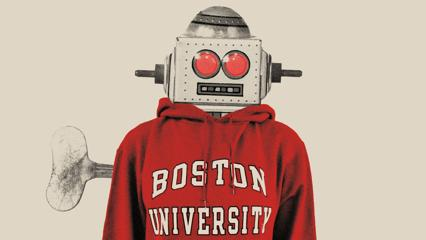

[Grad students go on strike at BU, dean recommends using AI substitutes.](https://www.thedailybeast.com/boston-university-suggests-replacing-striking-grad-students-with-ai) - The Daily Beast

___

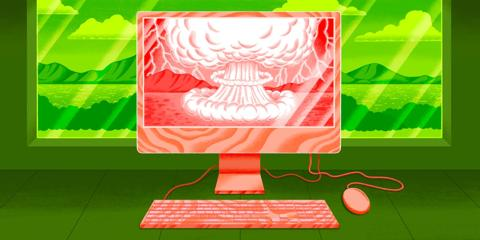

[The risks of handing decisions to computers with little transparency.](https://www.businessinsider.com/forget-ai-algorithm-apocalypse-driving-humans-lives-data-stock-market-2024-4) - Business Insider

___

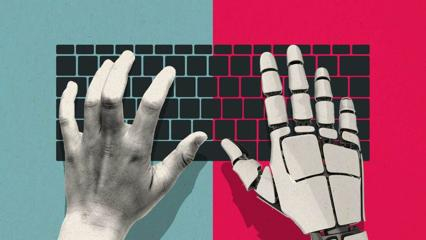

[Which industries are most worried about AI?](https://variety.com/vip/ai-spurs-job-security-concerns-in-u-s-media-ech-1235955935/) - Variety

___

It's not joblessness, it's 'me' time!

[Gene Munster predicts AI bull market just starting, might run 3 to 5 years and end in a bubble.](https://www.thestreet.com/technology/researcher-has-a-warning-about-the-future-of-the-ai-boom)

___

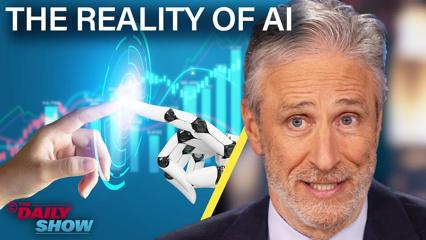

[Jon Stewart on AI - yeah it's gonna save the climate some day but first it's gonna eliminate your job tomorrow. Good luck as the VP of how to prompt AI to make toast!](https://www.youtube.com/watch?v=20TAkcy3aBY) - YouTube

___

[Hailo, another AI chip startup, raises $120m](https://www.bloomberg.com/news/articles/2024-04-02/hailo-raises-120-million-to-design-more-efficient-ai-chips)

___

[Larry Ellison: use AI to automate cybersecurity, and run everything in my cloud.](https://www.wsj.com/articles/its-time-to-hand-cybersecurity-over-to-the-computers-healthcare-industry-94858f48)

___

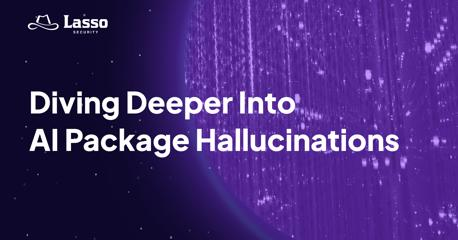

[Fake package hallucinated by AI gets 30k downloads, highlighting a cyberattack vector.](https://www.lasso.security/blog/ai-package-hallucinations)

___

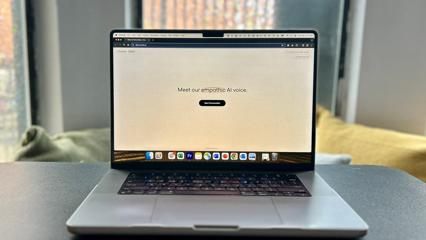

[Empathic AI makes me cry too](https://www.zdnet.com/article/an-ai-model-with-emotional-intelligence-i-cried-and-humes-evi-told-me-it-cared/#ftag=RSSbaffb68) - ZDNET

___

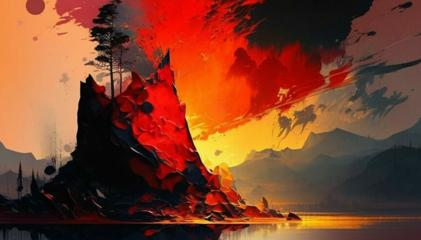

[People like AI art, when they are told it is made by humans. Just need the AI to concoct a backstory about a scruffy front and a cheeky art dealer to sell it.](https://www.sciencenorway.no/art-artificial-intelligence/people-liked-ai-art-when-they-thought-it-was-made-by-humans/2337417)

___

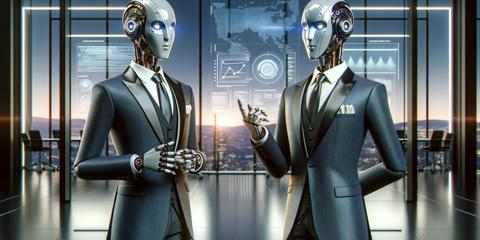

[ChatGPT and Perplexity AI Tweak Free Plans In Battle for Users - Decrypt](https://decrypt.co/224344/free-chatgpt-perplexity-logging-in-ads) - Decrypt

___

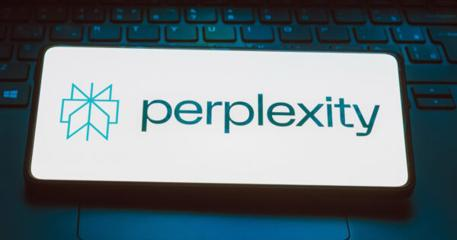

[Perplexity has a plan to sell ads](https://www.adweek.com/media/gen-ai-search-engine-perplexity-has-a-plan-to-sell-ads/)

___

[How MIT's David Autor Decided A.I. Might Benefit the Middle Class](https://www.nytimes.com/2024/04/01/business/ai-tech-economy.html)

___

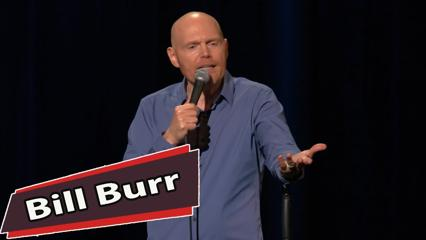

[Bill Burr: I'm afraid of robots (2022)](https://www.youtube.com/watch?v=ZjY2bUKrIhg#t=1m20s) - YouTube

___

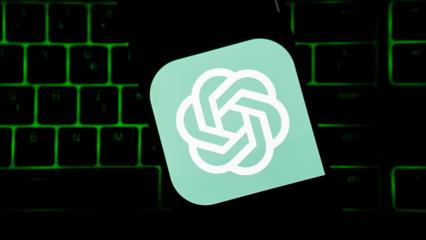

[ChatGPT will be open to all, and no longer require an account but with more content restrictions.](https://techcrunch.com/2024/04/01/chatgpt-no-longer-requires-an-account-but-theres-a-catch/) - TechCrunch

___

[WSJ profiles Demis Hassabis](https://www.wsj.com/tech/ai/the-chess-master-trying-to-propel-googles-ai-push-30c15788)

___

[I assume this is a joke, cool but I ain't reading all that tho](https://warontherocks.com/2024/04/from-war-on-the-rocks-to-ai-on-the-rocks-a-new-chapter-for-an-ambitious-project/)

___

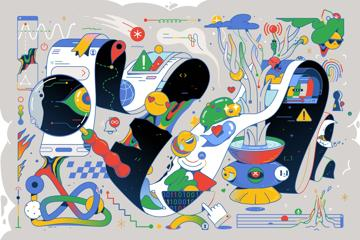

[Googles SGE gives much worse answers than expected, a lot more frequently than expected](https://www.washingtonpost.com/technology/2024/04/01/new-ai-google-search-sge/) - Washington Post

___

[If you want to train bigger LLMs, you need more data but we're getting to the point where they have used all the data, there literally is no more data.](https://www.wsj.com/tech/ai/ai-training-data-synthetic-openai-anthropic-9230f8d8)

___

[Will AI Boost Productivity? Or will it be like PCs when they took off, and economists said, you see tech everywhere except in the productivity statistics?](https://www.nytimes.com/2024/04/01/business/economy/artificial-intelligence-productivity.html)

___

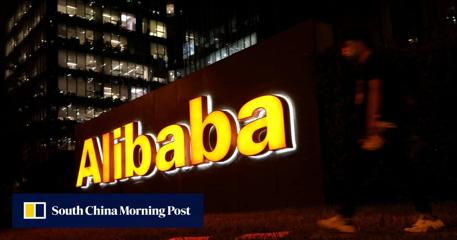

[April fools or no? I can't tell, you be the judge](https://www.scmp.com/tech/tech-trends/article/3257463/alibaba-test-rocket-parcel-delivery-service-lofty-attempt-ship-goods-anywhere-world-within-hour?utm_source=rss_feed) - South China Morning Post

___

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


[Apple has a paper on 'reference resolution'. A while back I scraped reddit threads for music with ChatGPT, it's was quite good at noticing, if someone said, 'Disturbed has a great cover', they were talking about 'The Sounds of Silence' mentioned in a parent post.](https://arxiv.org/pdf/2403.20329.pdf)

___

McKinsey's Iguazio releases a new BarkLM LLM for dogs

[AI shenanigans](https://www.ictworks.org/gates-foundation-genai-copilot/)

___

[Short sellers gonna have a field day with AI hype artists.](https://www.capybararesearch.com/reports/SoundHound-AI-Fake-Revenue-Fake-Bookings-and-Fake-AI/)

___

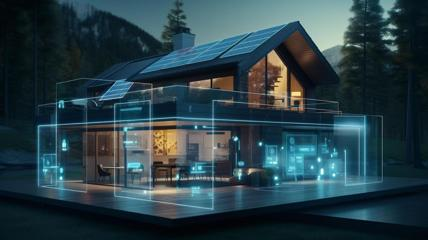

[Get ready to argue with your hallucinatory fridge.](https://www.forbes.com/sites/bernardmarr/2024/03/29/generative-ai-is-coming-to-your-home-appliances/?sh=2dfd12c87640) - Forbes

___

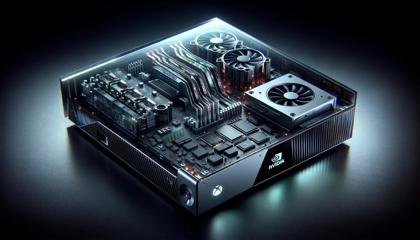

[Be wary of April Fools shenanigans today!](https://www.tweaktown.com/news/97253/nvidia-buys-xbox-brand-from-microsoft-next-gen-has-dual-gpus-ai-to-fight-playstation-6/index.html) - TweakTown

___

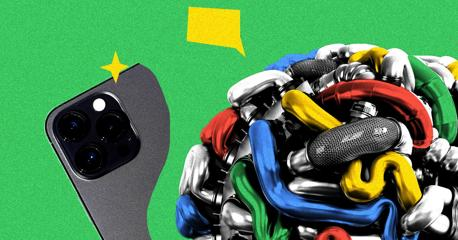

[Maybe Super Siri, possibly with a pin companion, could record your life and let you ask questions about it, never forget someone's name they just told you or where you left your keys](https://www.wired.com/story/apple-google-gemini-iphone/) - WIRED

___

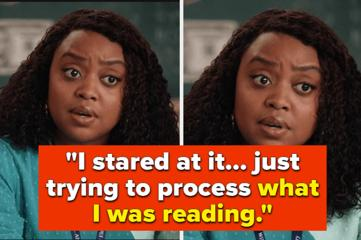

[AI horror stories in education. Hey learning to copy and paste is a skill.](https://www.yahoo.com/lifestyle/educators-sharing-student-ai-changed-200945857.html) - Yahoo Life

___

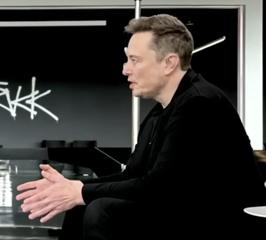

[Musk: AGI next year](https://www.webpronews.com/elon-musks-bold-prediction-artificial-general-intelligence-by-2025/) - WebProNews

___

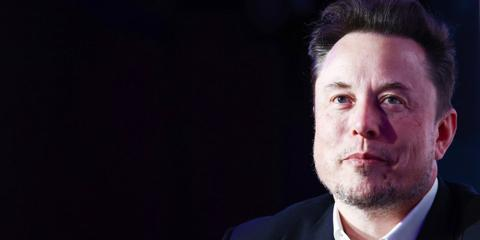

[Elon says 20% chance AI destroys humanity, but full steam ahead anyway.](https://www.businessinsider.com/elon-musk-20-percent-chance-ai-destroys-humanity-2024-3) - Business Insider

___

[The MAD landscape 2024, if you need to wallpaper the Great Wall or something. mattturck.com/mad2024/](https://mattturck.com/mad2024/)

___

[When emotional AI crosses that uncanny valley, which it's starting to do, it's freaky and you have to ask if that is good or healthy or ethical. Maybe all robots should be recognizable as robots and stay on the C3PO side of the uncanny value.](https://theconversation.com/increasingly-sophisticated-ai-systems-can-perform-empathy-but-their-use-in-mental-health-care-raises-ethical-questions-225498)

___

[Survey: 40 Percent of Managers Hope to Replace Some Workers With AI This Year.](https://www.inc.com/kit-eaton/report-forty-precent-of-managers-hope-to-replace-some-workers-with-ai-this-year.html)

___

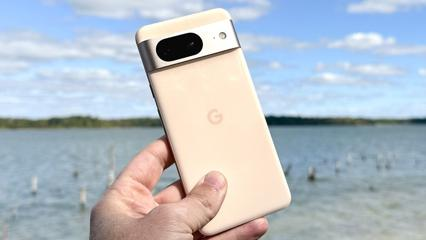

[Google having trouble keeping its story straight about on-device Nano AI on Pixels, now says RAM is the problem but you will be able to turn it on via a developer option.](https://www.tomsguide.com/phones/pixel-8s-initial-gemini-ai-snub-was-down-to-ram-google-says) - Tom's Guide

___

[OpenDevin attempts to replicate the Devin AI software engineer with open source www.geeky-gadgets.com/opendevin-ai...](https://www.geeky-gadgets.com/opendevin-ai-software-engineer/)

___

[What Fritz Lang's 1927 Metropolis has to teach us about the AI revolution.](https://www.bloomberg.com/opinion/articles/2024-03-31/ai-may-turn-the-economy-into-a-disaster-movie-lufgz9kg)

___

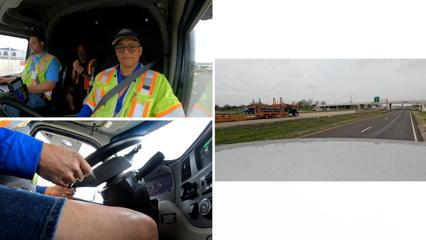

[Self-driving trucks coming to America's highways. I could sort of see 2 drivers accompanying a 10-truck train between depots without local driving. Independent self-driving trucks can get stuck in the middle of nowhere or hijacked, and longer trains can create traffic problems.](https://www.washingtonpost.com/technology/2024/03/31/autonomous-semi-truck-jobs-regulation/) - Washington Post

___

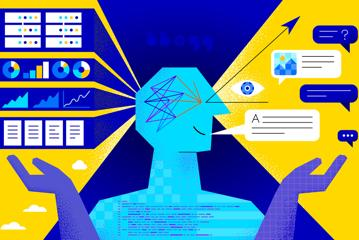

[MIT paper starts to figure out how LLMs store a knowledge graph. IIUC they write functions that look up information in the params to answer questions like, what instrument does Miles Davis play, without running the full LLM. If you know how info is stored, then you can update it without retraining.](https://news.mit.edu/2024/large-language-models-use-surprisingly-simple-mechanism-retrieve-stored-knowledge-0325) - MIT News | Massachusetts Institute of Technology

___

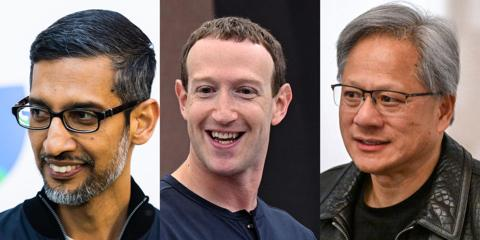

[Satya Nadella is truly the GOAT, says his greatest use case for gen-AI was helping him understand Heidegger.](https://www.businessinsider.com/ai-hacks-of-execs-including-meta-google-and-microsofts-ceo-2024-3#meta-ceo-mark-zuckerberg-built-a-personal-ai-assistant-called-jarvis-to-manage-different-parts-of-his-home-9) - Business Insider

___

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


[Fed economists ask, does gen-AI represent a turning point in the labor share of national income, and will it go up or down?](https://www.philadelphiafed.org/-/media/frbp/assets/economy/articles/economic-insights/2024/q1/eiq124-generative-ai-a-turning-point-for-labors-share.pdf?utm_source=pocket_saves)

___

[Will gen-AI make labor more productive and workers more empowered, or gig-ify everything?](https://www.politico.com/news/magazine/2024/03/31/ai-labor-power-schuler-00144086)

___

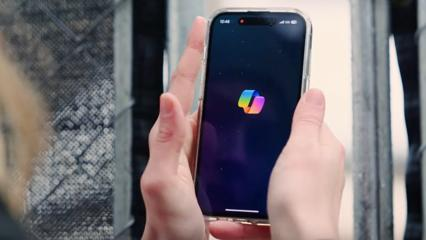

[Exploring Chicago with Copilot, who needs travel buddies or bar debates about deep dish vs tavern pizza?](https://www.zdnet.com/article/microsoft-has-a-clever-way-of-showing-you-ai-is-normal-especially-if-youre-alone/) - ZDNET

___

[Demis Hassabis says there is an excess of AI hype and at the same time we underrate the progress AI will deliver humanity, wishes we focused more on science and less on hacking.](https://www.ft.com/content/774901e5-e831-4e0b-b0a1-e4b5b0032fb8)

___

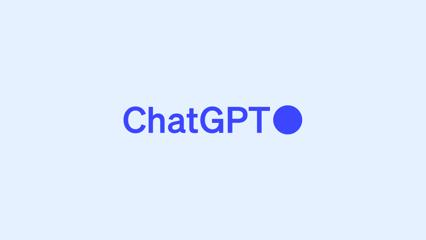

[ChatGPT is predictably wishy-washy on this question](https://chat.openai.com/share/0bb30f44-d6ec-4d6b-8521-4c0d60230650)

___

Does ChatGPT disprove Chomsky's universal grammar? I think we speak like ChatGPT and human grammar would be more consistent if it was innate. But a child only hears maybe a few million words by age 5. Maybe there is at least a universal tokenizer or a tiny bit of low-level innate language circuitry?

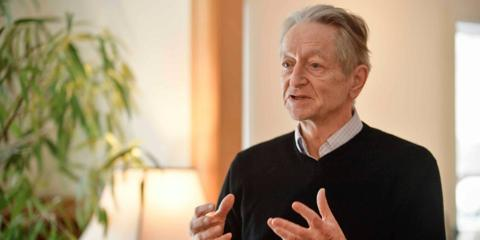

[A Nikkei interview with Geoffrey Hinton.](https://asia.nikkei.com/Business/Technology/Godfather-of-AI-speaks-on-threat-of-tech-surpassing-humanity) - Nikkei Asia

___

In [123]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))


for i, post in enumerate(data.feed):
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = get_og_tags(post_url)
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

In [51]:
data.feed[0].post.record.embed.external.thumb.dict()

AttributeError: 'Main' object has no attribute 'external'

In [ ]:
data.feed[0].post.record.embed.dict()

In [ ]:
print(datetime.now())

In [ ]:
pd.read_sql_query("select * from news_articles where article_date > '2024-03-23'", conn)


In [68]:
data

Response(feed=[FeedViewPost(post=PostView(author=ProfileViewBasic(did='did:plc:qomkdnxrqw3gkbytdxea5z65', handle='skynetandchill.com', associated=None, avatar='https://cdn.bsky.app/img/avatar/plain/did:plc:qomkdnxrqw3gkbytdxea5z65/bafkreifrqqv5leasjhgndik4yisfzpmes35jakmgwqdnwpw6hd4kzni66u@jpeg', display_name='SkynetAndChill.com', labels=[], viewer=ViewerState(blocked_by=False, blocking=None, blocking_by_list=None, followed_by=None, following=None, muted=False, muted_by_list=None, py_type='app.bsky.actor.defs#viewerState'), py_type='app.bsky.actor.defs#profileViewBasic'), cid='bafyreihkywyhqekfpzzylll2mxlr4ok3l3phwxio3fodezell65kgwxqiu', indexed_at='2024-03-29T14:51:41.637Z', record=Record(created_at='2024-03-29T14:51:41.637Z', text="You're not afraid of the AI, you're afraid of what the sophomoric techbros, maleducated morons, and master manipulators in a non-human-centered culture and economy will do with the AI\nhackernoon.com/no-you-are-n...", embed=Main(external=External(descripti